In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda:5"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [2]:
import torch
from tqdm import tqdm
from torch.nn.functional import pad

def perplexity_of_fixedlength_models(dialog):
    
    max_length = model.config.n_positions
    stride = 1
    
    pad_token_id = 0
    encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    seq_len = encodings.input_ids.size(1)
    padding_len = max_length -1 
    padded_input_ids = pad(torch.tensor([], dtype=torch.long), (0, padding_len), value=pad_token_id).unsqueeze(dim=0)
    encodings.input_ids = torch.cat([padded_input_ids, encodings.input_ids], dim=1)
    seq_len = encodings.input_ids.size(1)
    
    nlls = []
    prev_end_loc = padding_len
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from max_length on the last loop 
        begin_loc = max(padding_len, begin_loc)
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood.item())

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    return nlls

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = r'\[([^\]]+)\]'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, pattern=r'<([^>]+)>'):
    
    encodings = torch.cat(tokens)
    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, pattern=r'\[([^\]]+)\]'):

    encodings = torch.cat(tokens)
    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl

def compute_per_user_mean_perplexity(dialog, tokens, perpl, pattern=r'\[([^\]]+)\]'):
    
    encodings = torch.cat(tokens)
    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl
    
def compute_graph_perplexity(tokens, perpl, pattern = r'\[([^\]]+)\]', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(perpl)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            perpl_per_sent = perpl[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(perpl_per_sent), label=f'{patt}')
            mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(mean_value, color='r', label=f':{mean_value:.2f}')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()

[nltk_data] Downloading package punkt to /u/sebono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /u/sebono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Topical-Chat Dataset

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [36]:
topical_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/topical/conversations.csv")
topical_df

file_name  \
0      t_c04d2b82-ecc0-4128-b5de-91bb3211fe47   
1      t_e7ccc97b-ae46-4d80-96db-d4a67eb13835   
2      t_deac92a0-cd57-4f8a-9094-e4455cfdd05d   
3      t_02208dca-256d-4fef-8a58-e3cb30625222   
4      t_34351a42-4b9d-47e2-99f2-f32efb789a9c   
...                                       ...   
10779  t_56ef264f-af34-42ff-ac54-0f8d5a47e8b4   
10780  t_1a8383a5-2c8d-4687-b26e-3434b6d7fd91   
10781  t_46a82c75-d203-49c5-9d9a-2e03085d829b   
10782  t_e959a00e-5928-411f-9933-347edb6edf6b   
10783  t_884c3d36-67da-41a1-b432-6aa8601d31f7   

                                            file_content  
0      <SPK1> Hello! Do you like rock music? <SPK2> H...  
1      <SPK1> Hi, how are you today? Do you like rock...  
2      <SPK1> Hi! So do you like music? I love rock m...  
3      <SPK1> Hello.  Do you like Rock Music?  Rock m...  
4      <SPK1> hi how are you doing over there?  <SPK2...  
...                                                  ...  
10779  <SPK1> Good Morning! <SPK2> Good morning. How ...  
10780  <SPK1> Do you watch television at all?  <SPK2>...  
10781  <SPK1> Do you watch a lot of TV? <SPK2> I do! ...  
10782  <SPK1> Hi, how are you? <SPK2> Well thank you....  
10783  <SPK1> Are you a fan of football by any chance...  

[10784 rows x 2 columns]

In [50]:
import os 
import pickle
from tqdm import tqdm


data = []
perplexity_scores = {}
perplexity_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/topical/"
for filename in tqdm(os.listdir(perplexity_path)):
    if filename.endswith('.pkl'):
        with open(os.path.join(perplexity_path, filename), 'rb') as f:
            file_data = pickle.load(f)
            key = list(file_data.keys())[0]
            value = file_data[key]
            perplexity_scores[key] = value

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 417.94it/s]


In [51]:
perplexity_scores.keys()

dict_keys(['t_dece2e05-2a20-4d3b-be0d-48fc6a2f99b9', 't_7a9c6b5e-5954-4875-9789-26417cdc03b5', 't_5944211d-6db6-4fe7-8a7c-0b8483656d1b', 't_c9e5af6d-006d-4d3d-9ec6-d5ffcedae8ec', 't_c04d2b82-ecc0-4128-b5de-91bb3211fe47', 't_4467227b-12a7-4cb9-85a7-787c6124fc5b', 't_02208dca-256d-4fef-8a58-e3cb30625222', 't_deac92a0-cd57-4f8a-9094-e4455cfdd05d', 't_e1725cf0-efd9-4263-9ecd-7d295c93837c', 't_17de86c8-fe2f-4fd9-9ad4-d08a2e0f63db', 't_e7ccc97b-ae46-4d80-96db-d4a67eb13835', 't_02e16114-ec74-498d-abce-ea82bd552c1a', 't_c7d8497f-67ad-4627-902e-83b2d5045161', 't_73e87509-da10-4f8d-b84c-dafed9e22646', 't_8bab1d48-4ced-411a-93ea-a66e3a9c27f5', 't_aaec6b4f-207d-41a8-a750-34c87d03d4e2', 't_f2307da8-e846-4c9f-a33e-8cec712c4fdd', 't_34351a42-4b9d-47e2-99f2-f32efb789a9c', 't_c583e996-138a-4f95-93df-e39b00d3ea0e', 't_7361752b-9809-4a9b-9252-8389748bd248', 't_3a79aa8d-1648-4920-b424-b5941158360e', 't_7b12fa69-aaaf-4070-b84f-de0c37e0d535', 't_2ae10014-f535-4321-af20-6f6692b6cf59'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


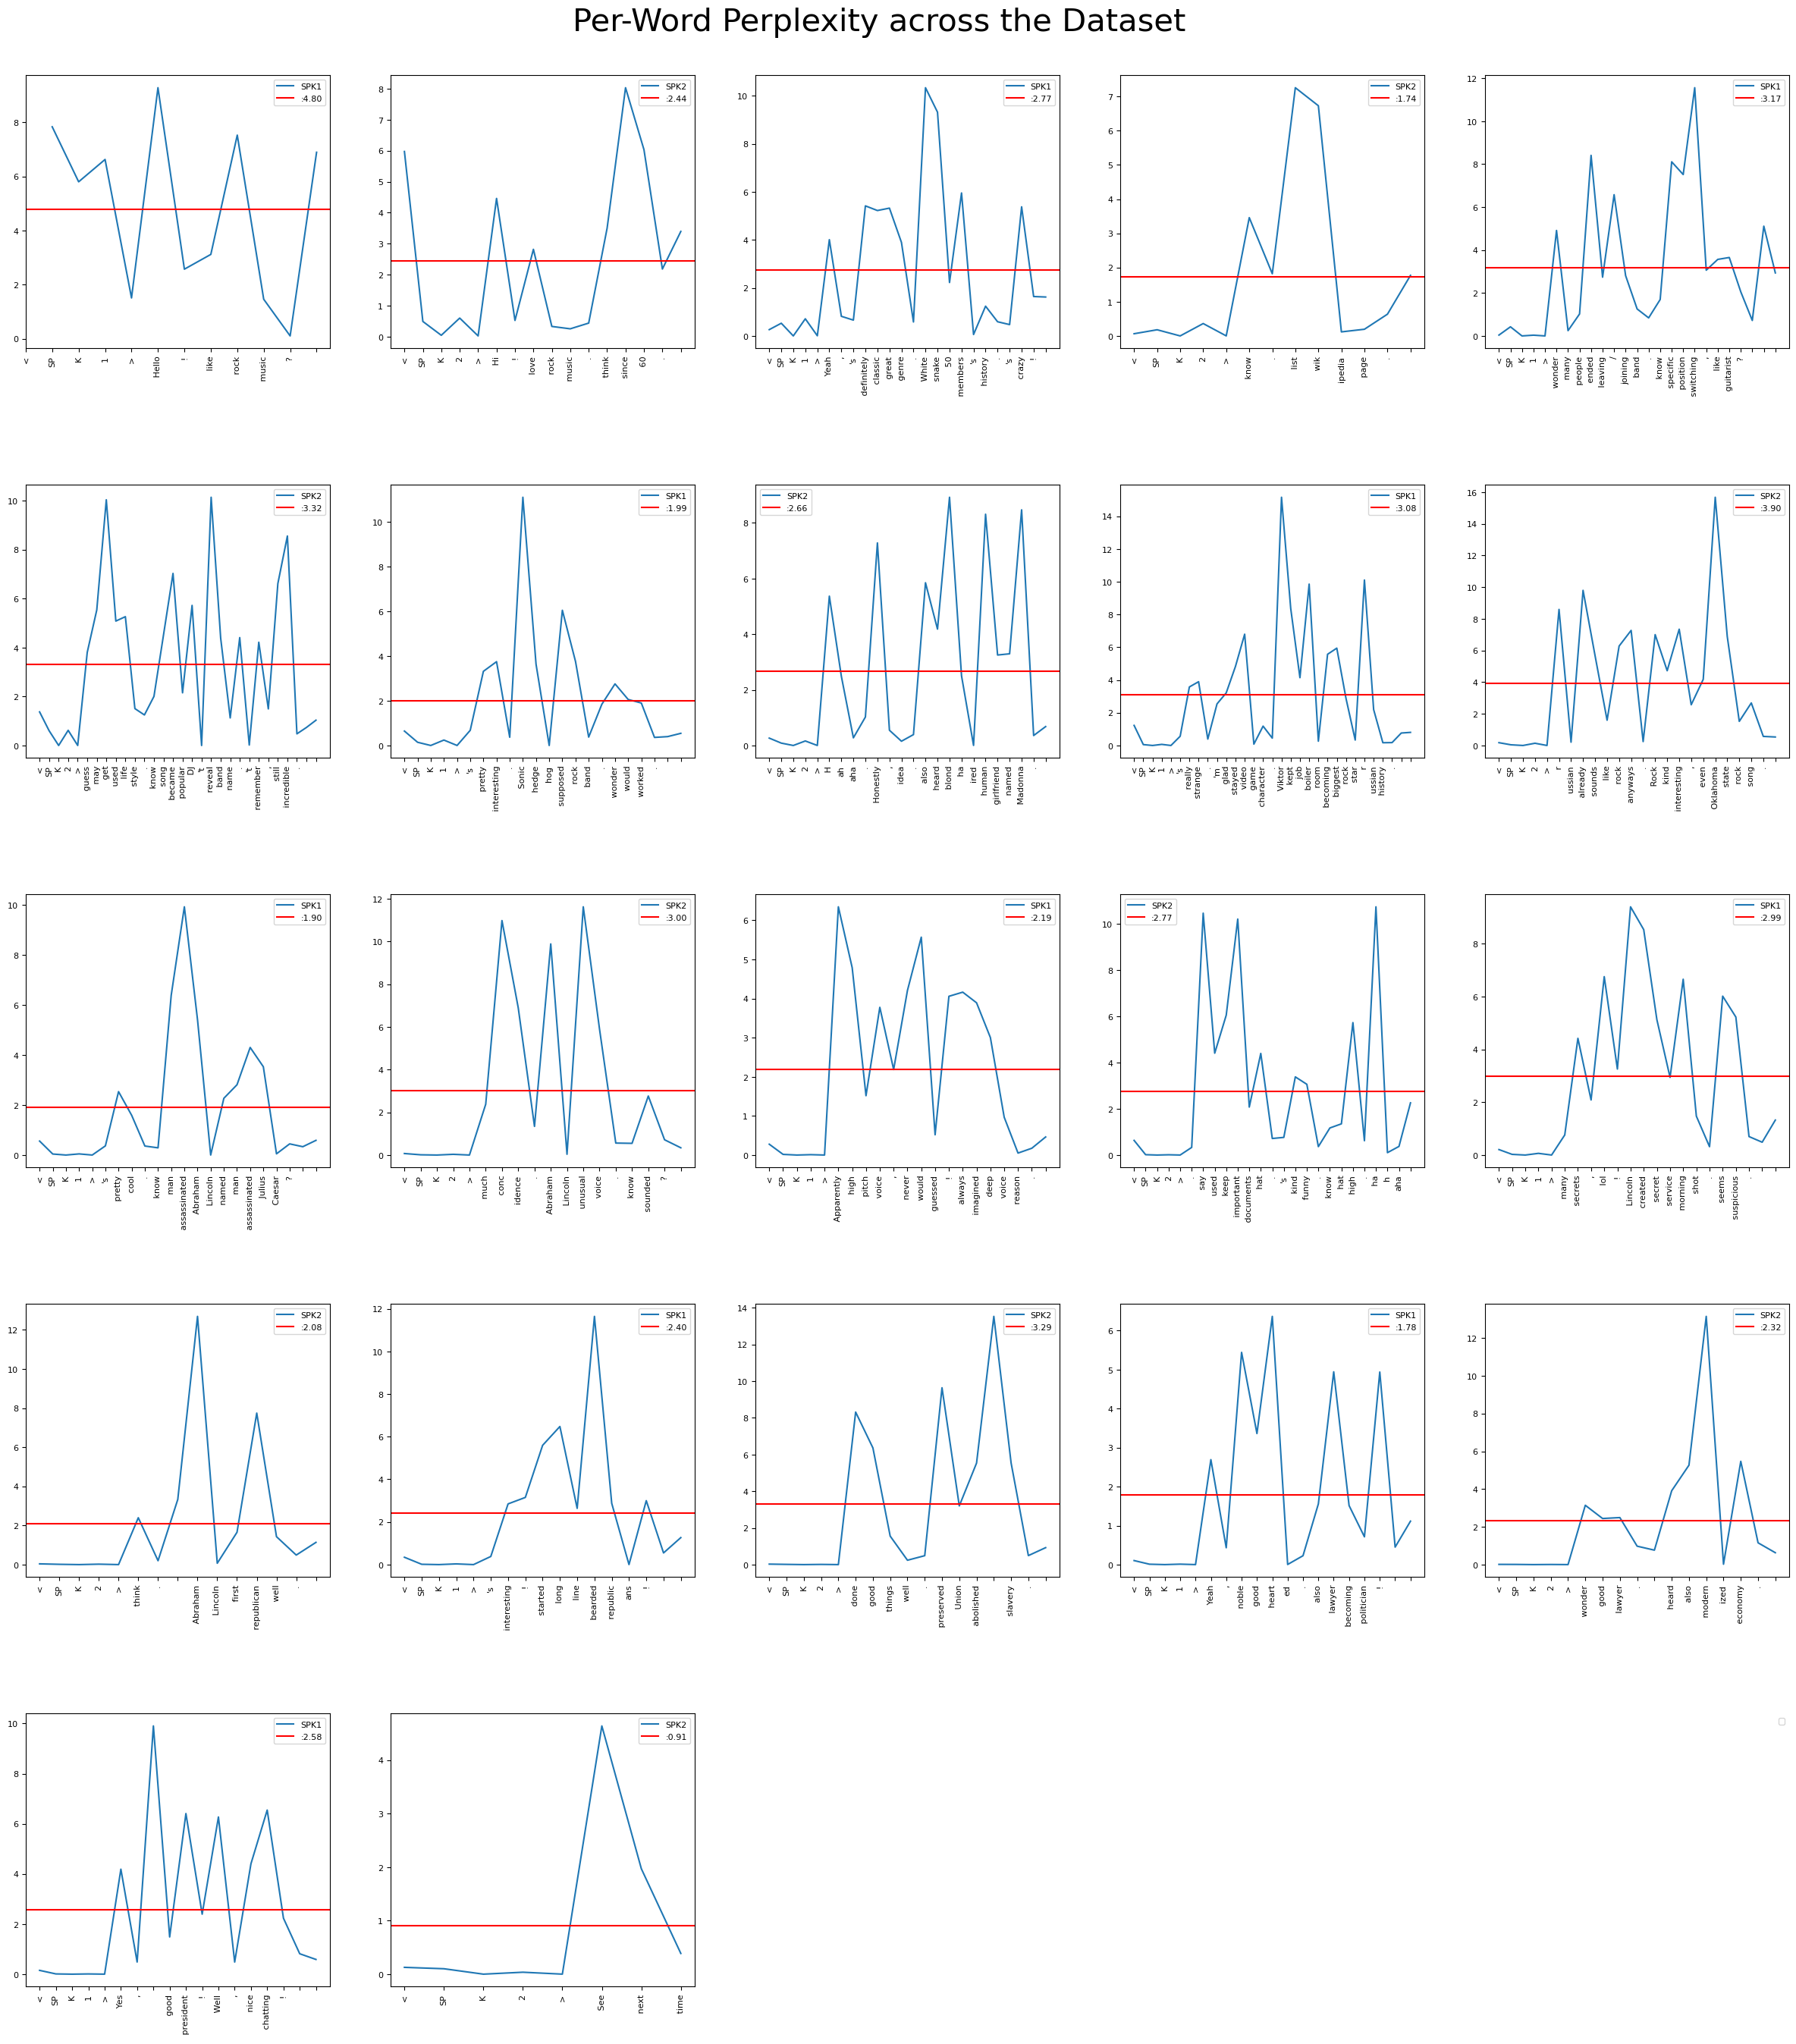

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


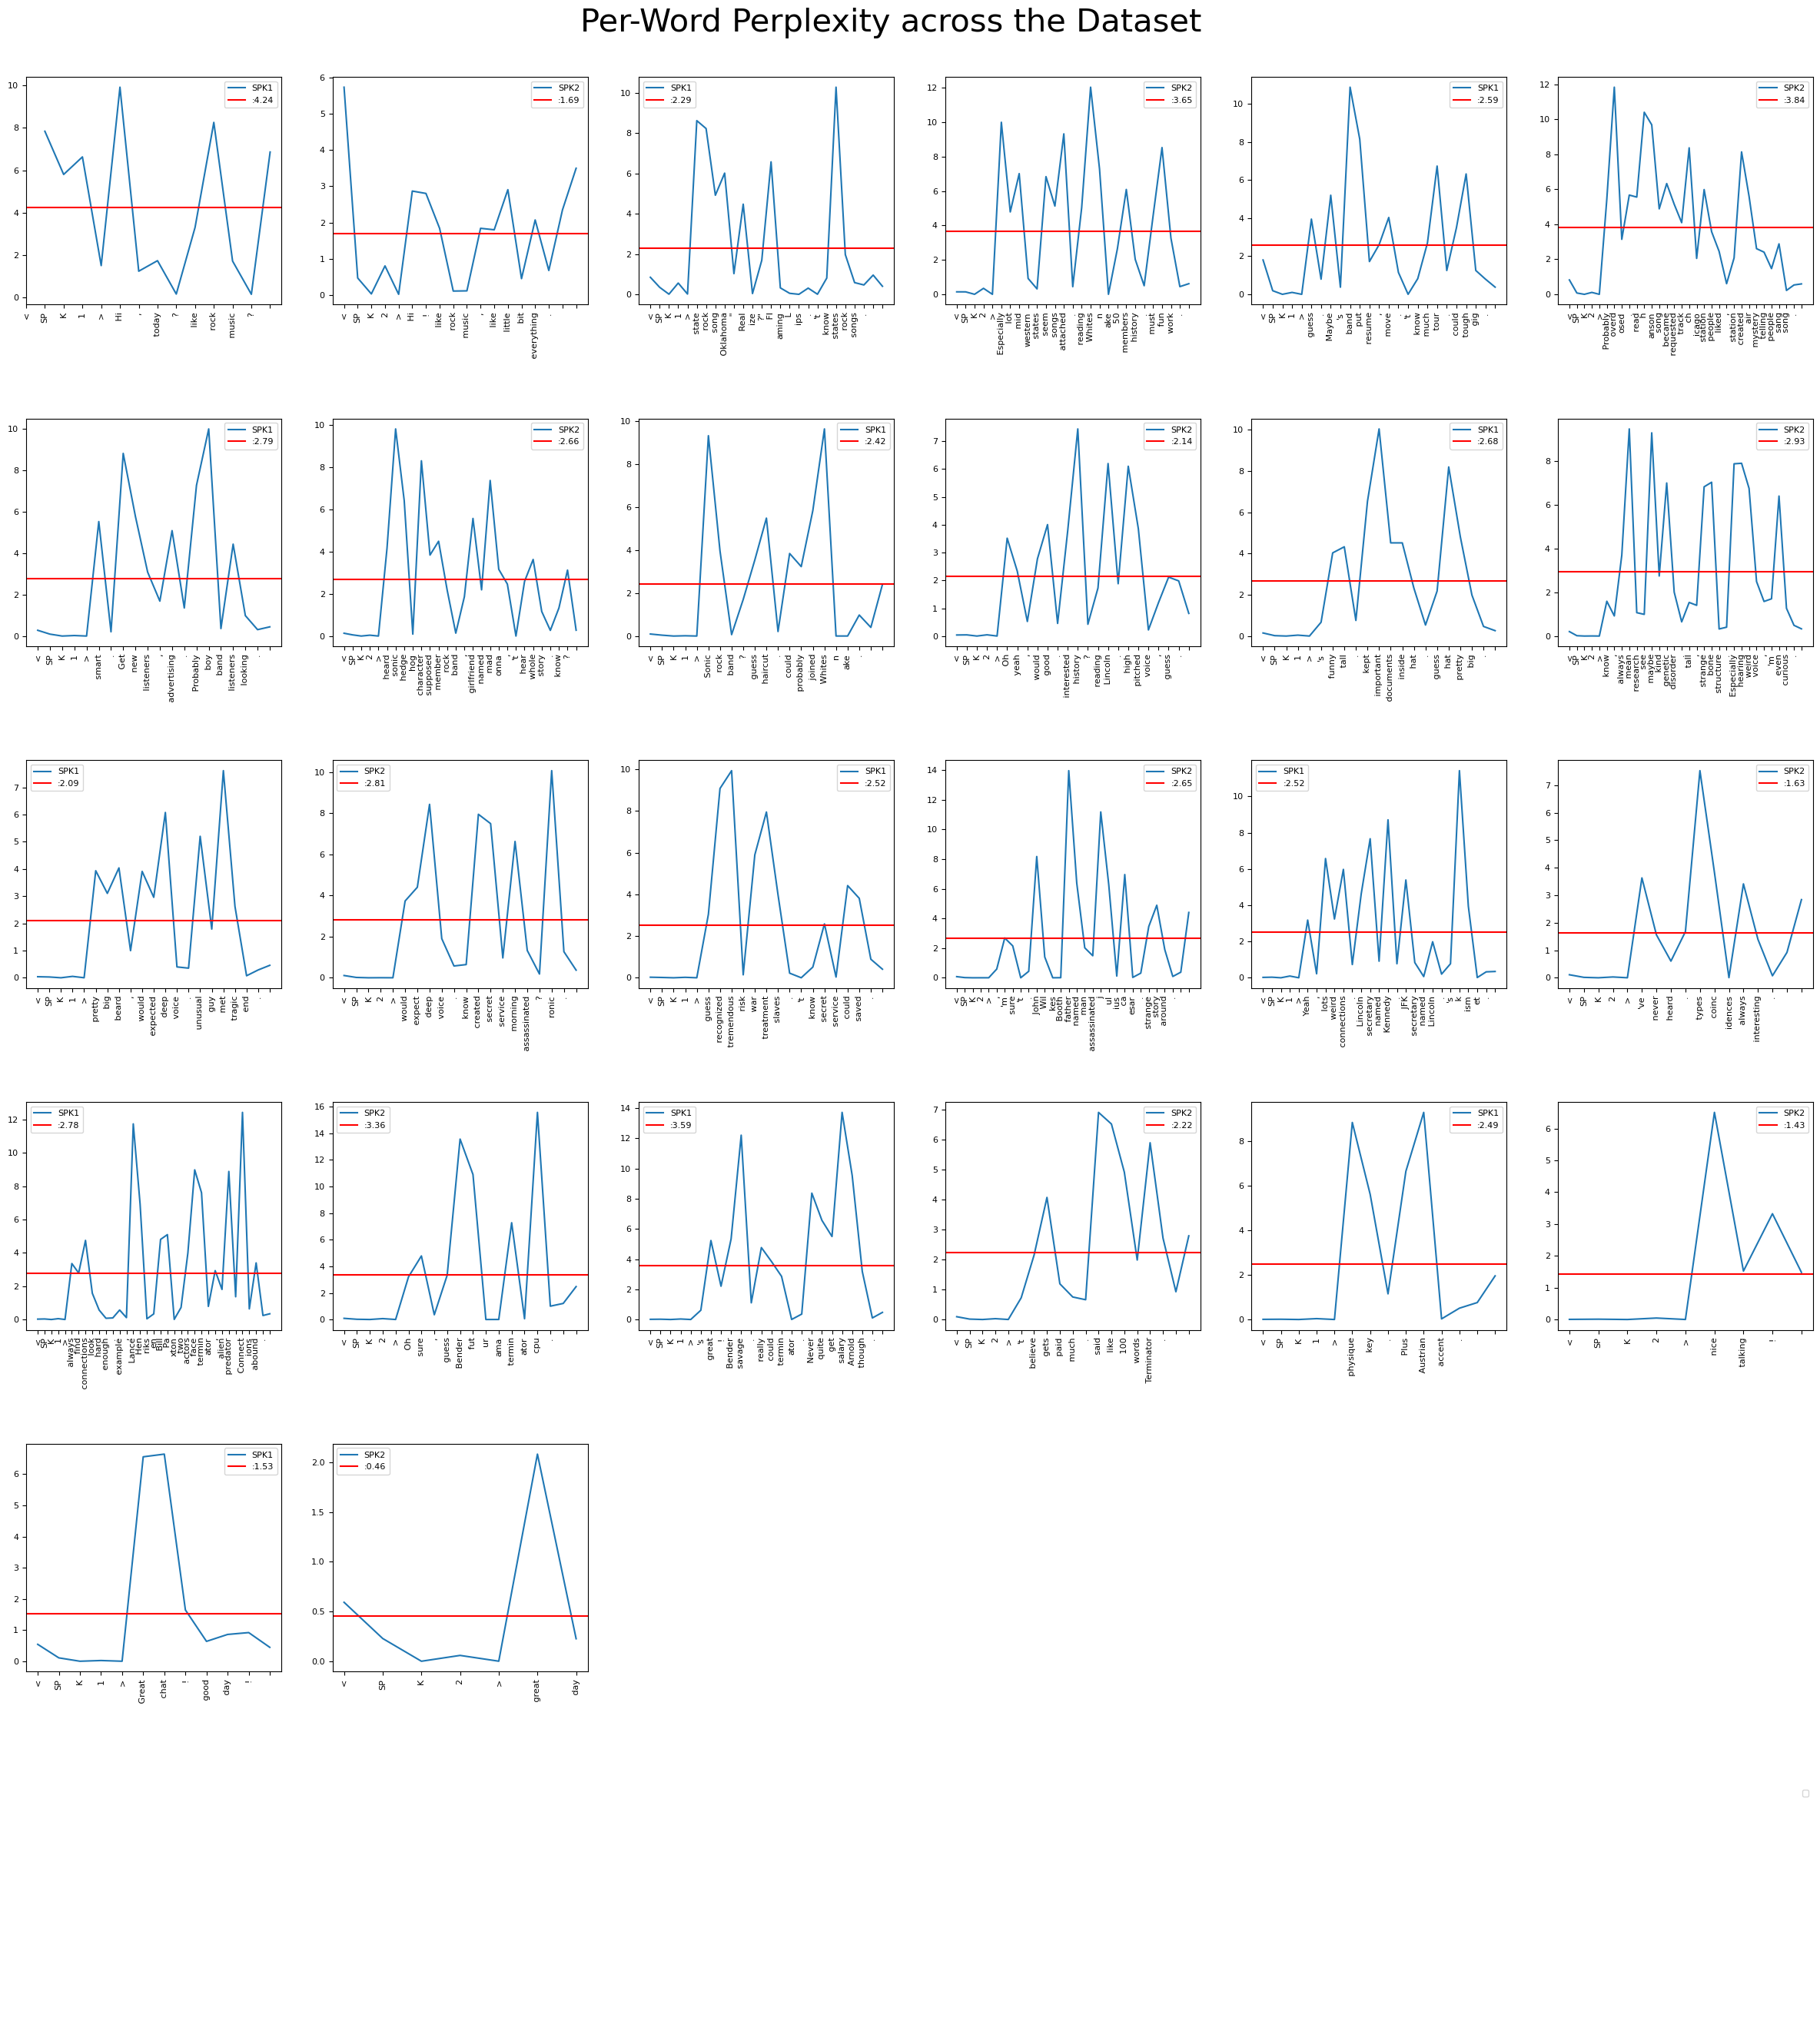

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


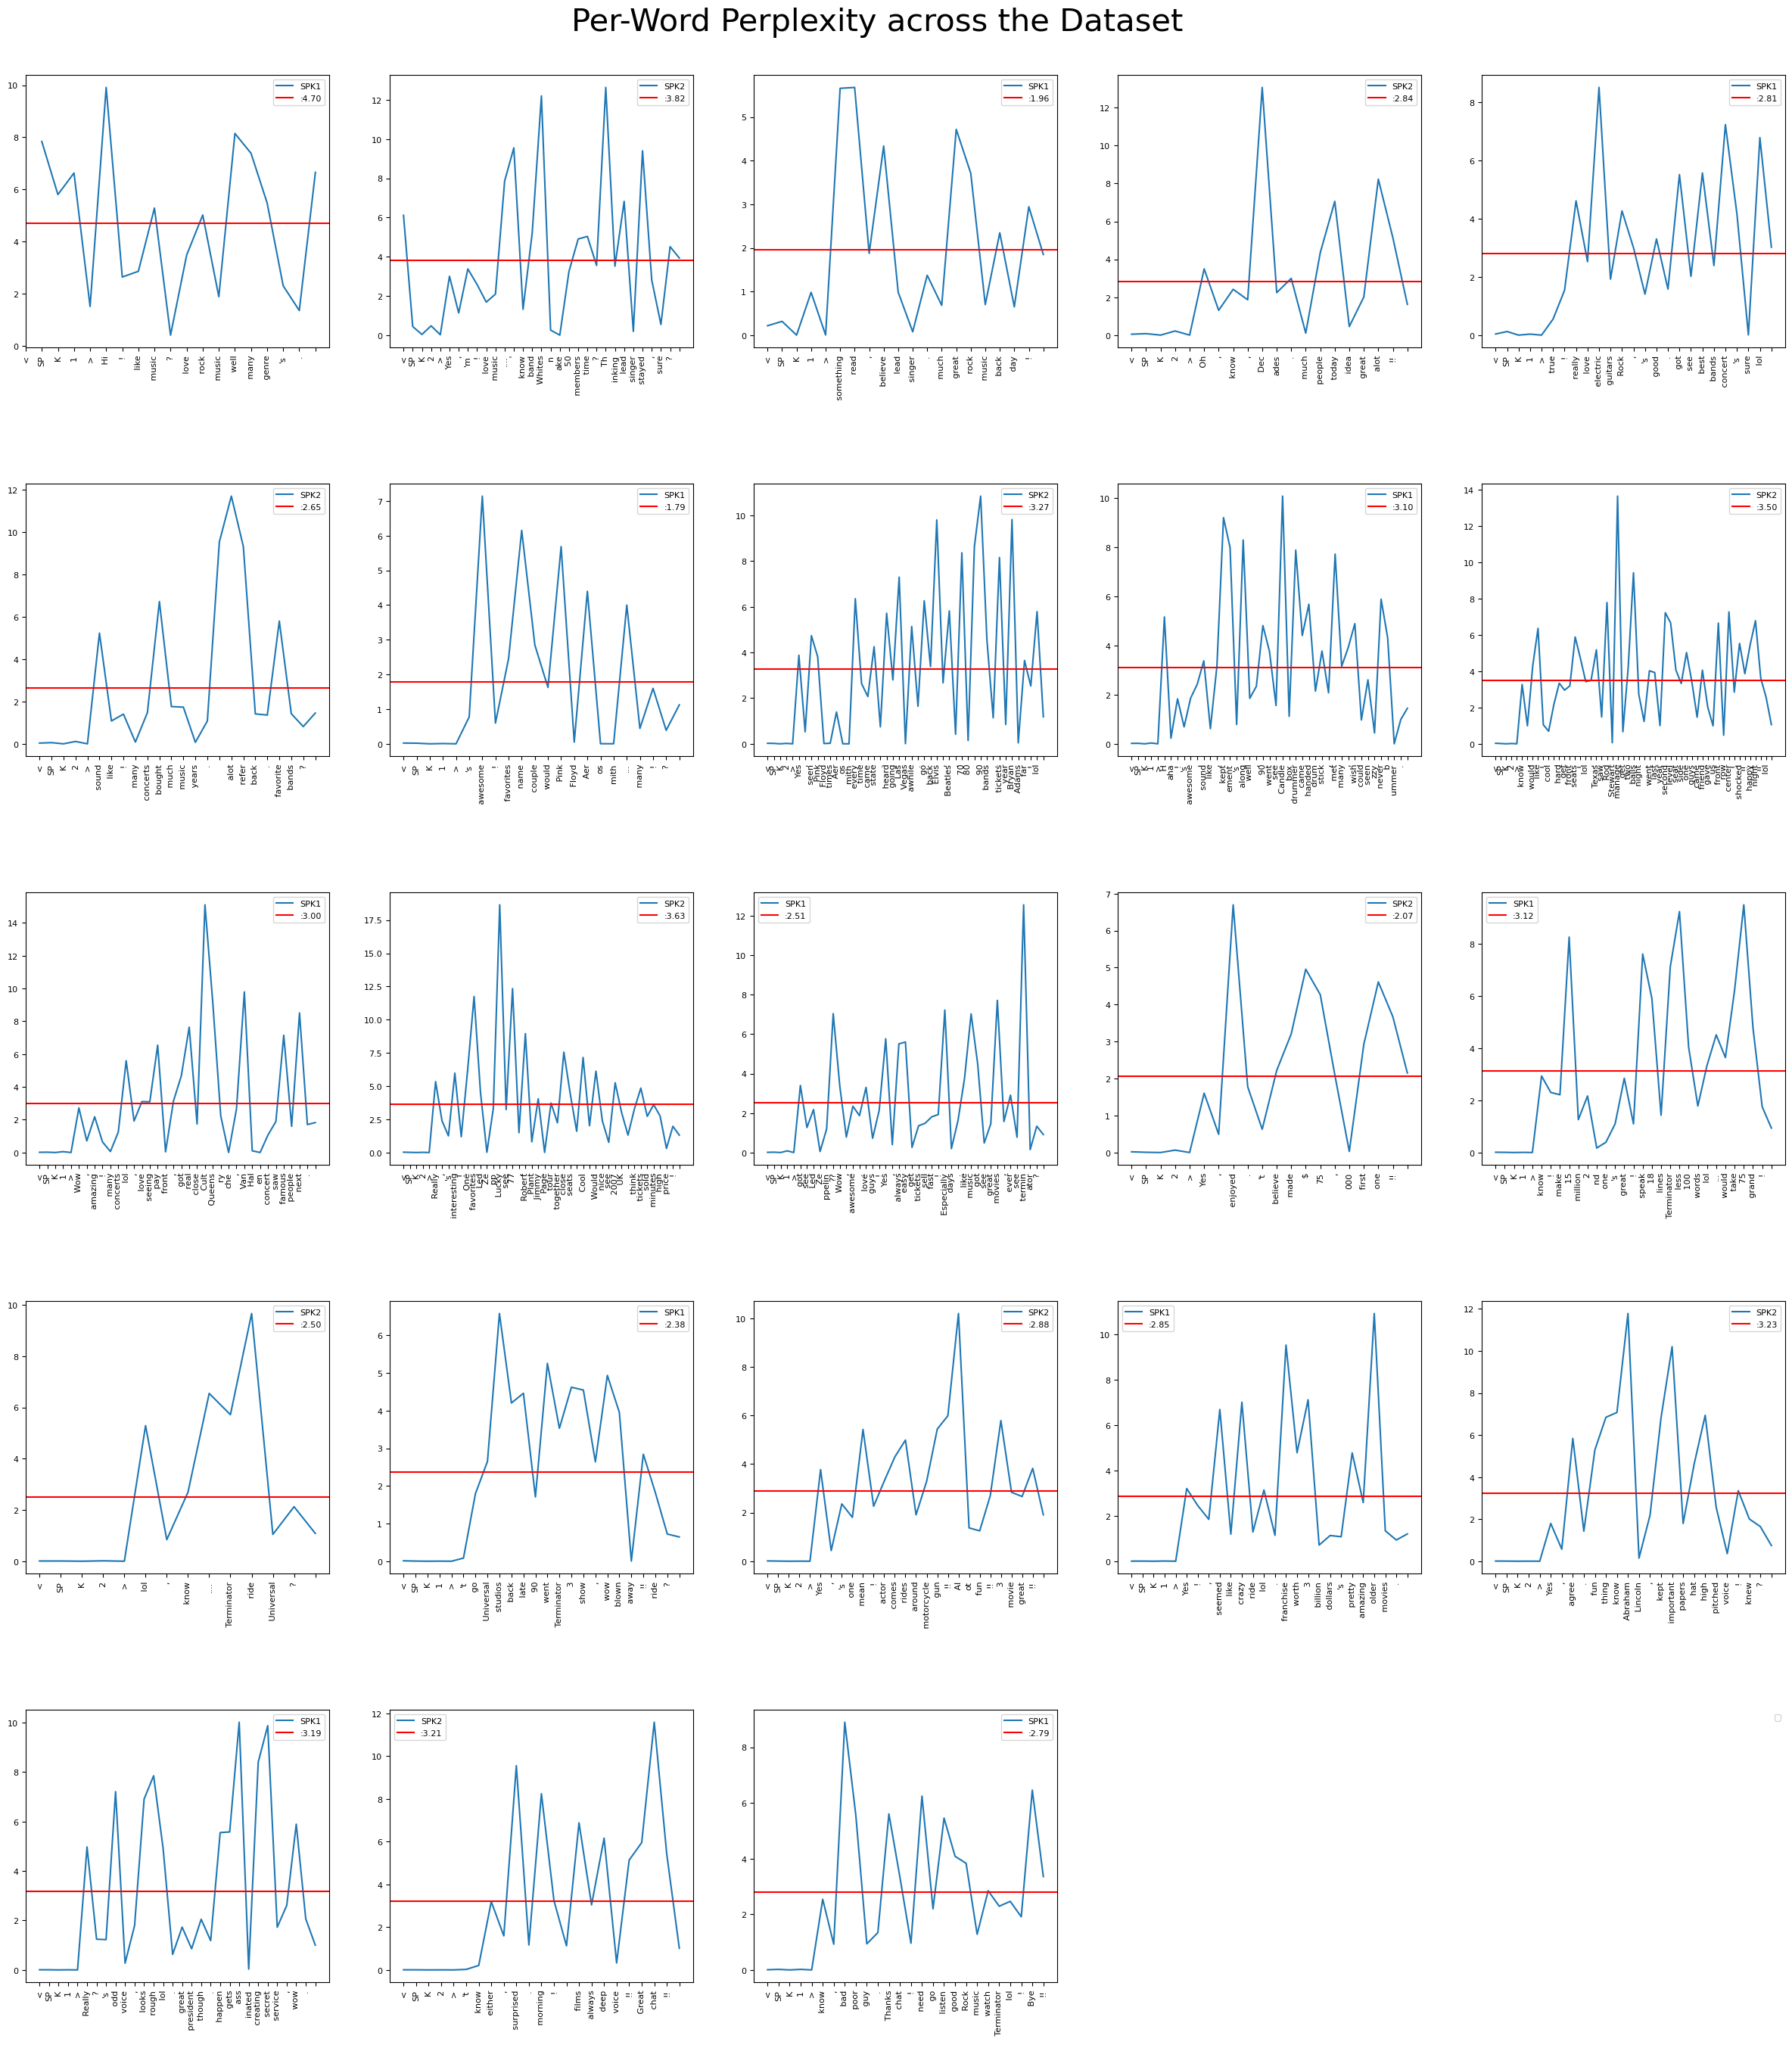

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


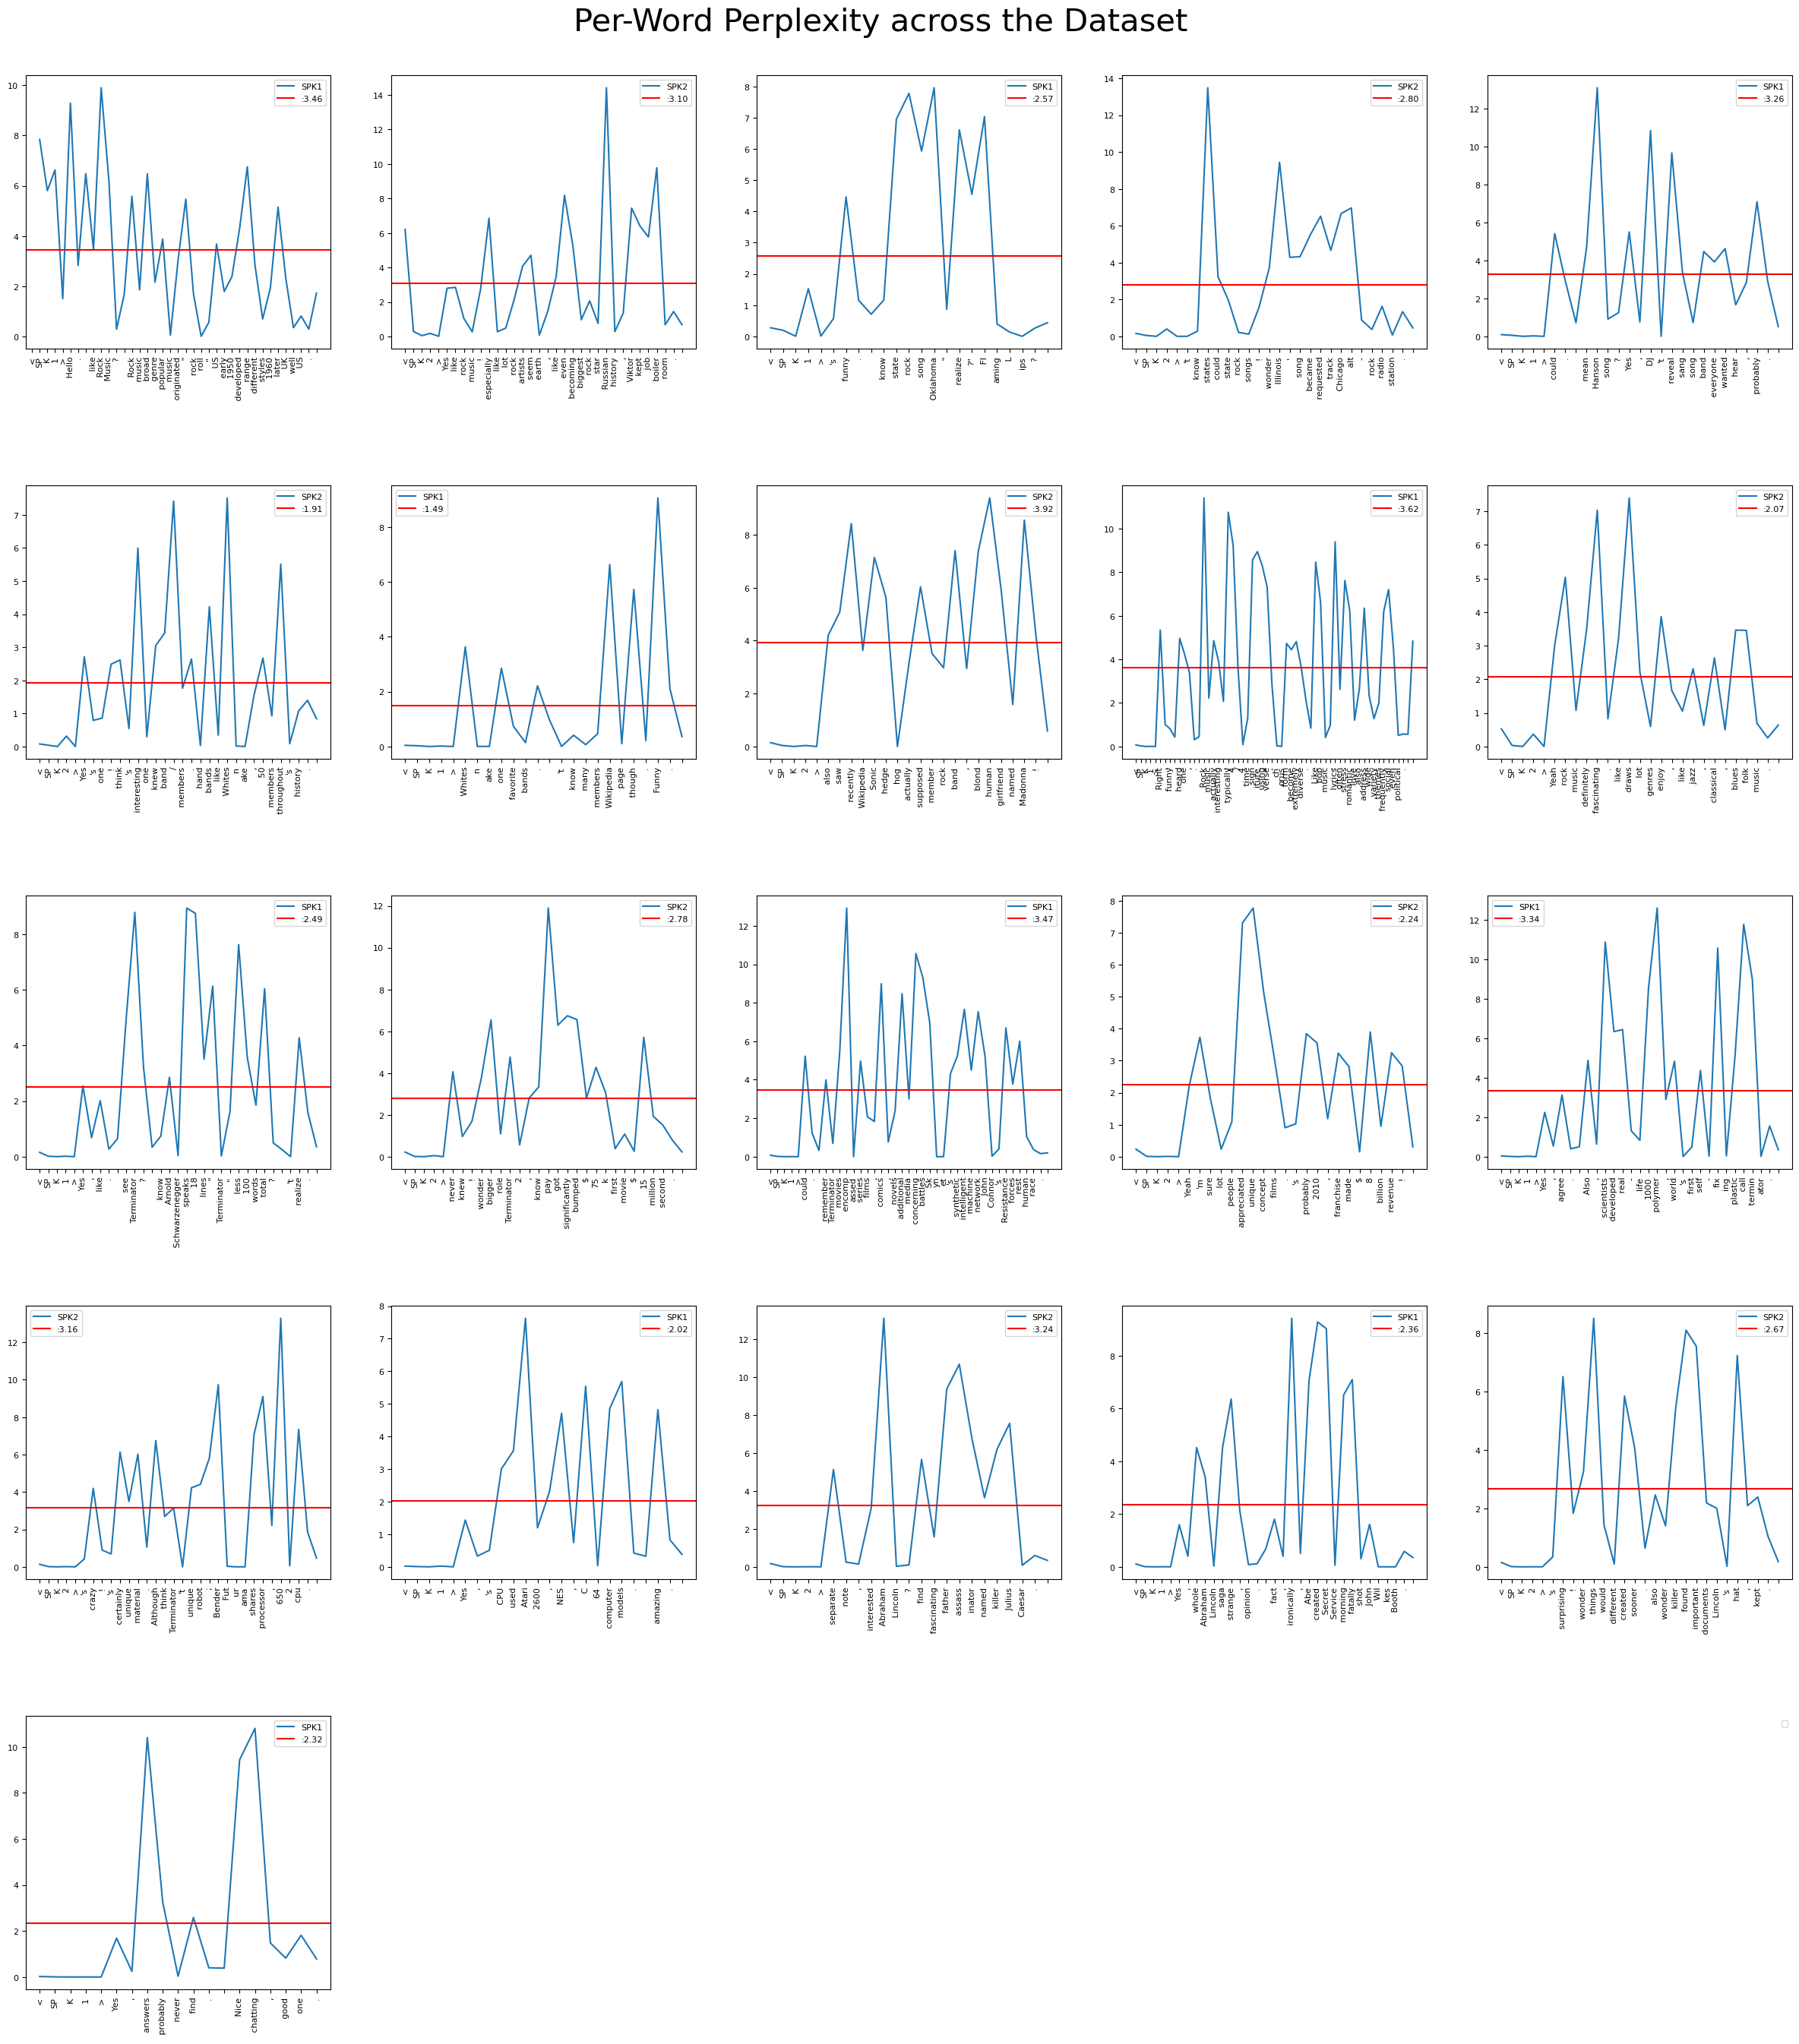

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


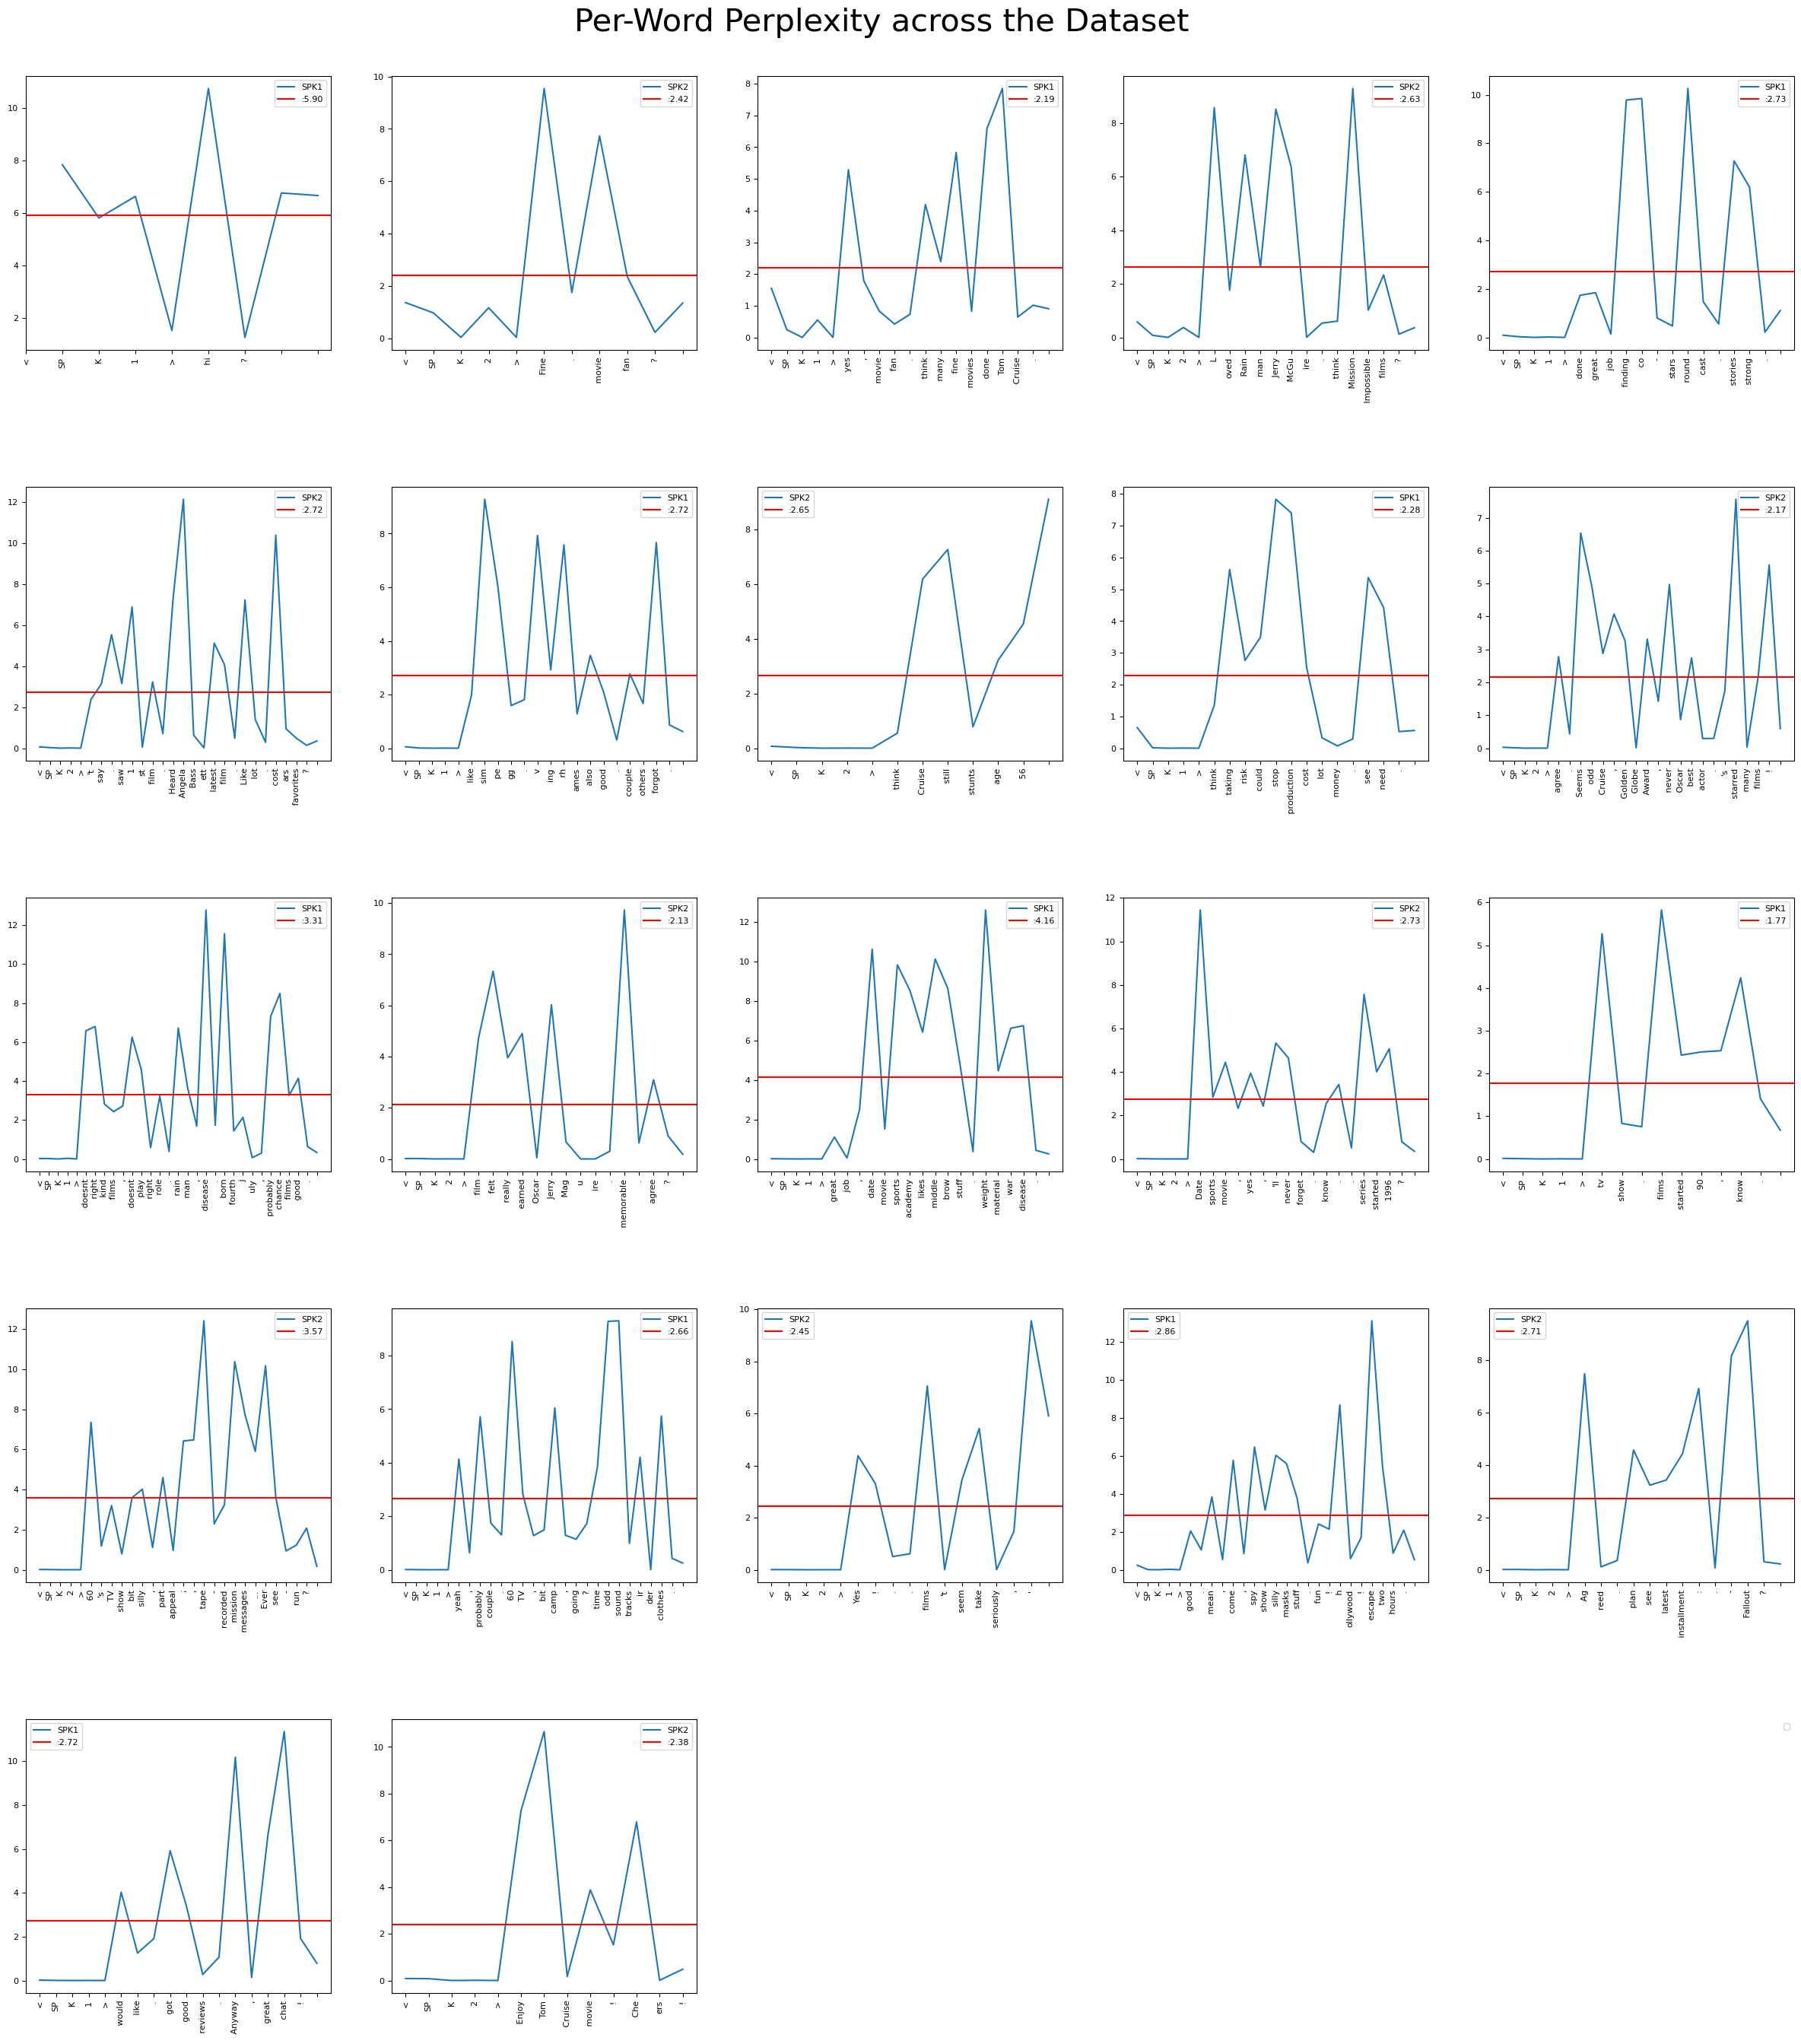

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


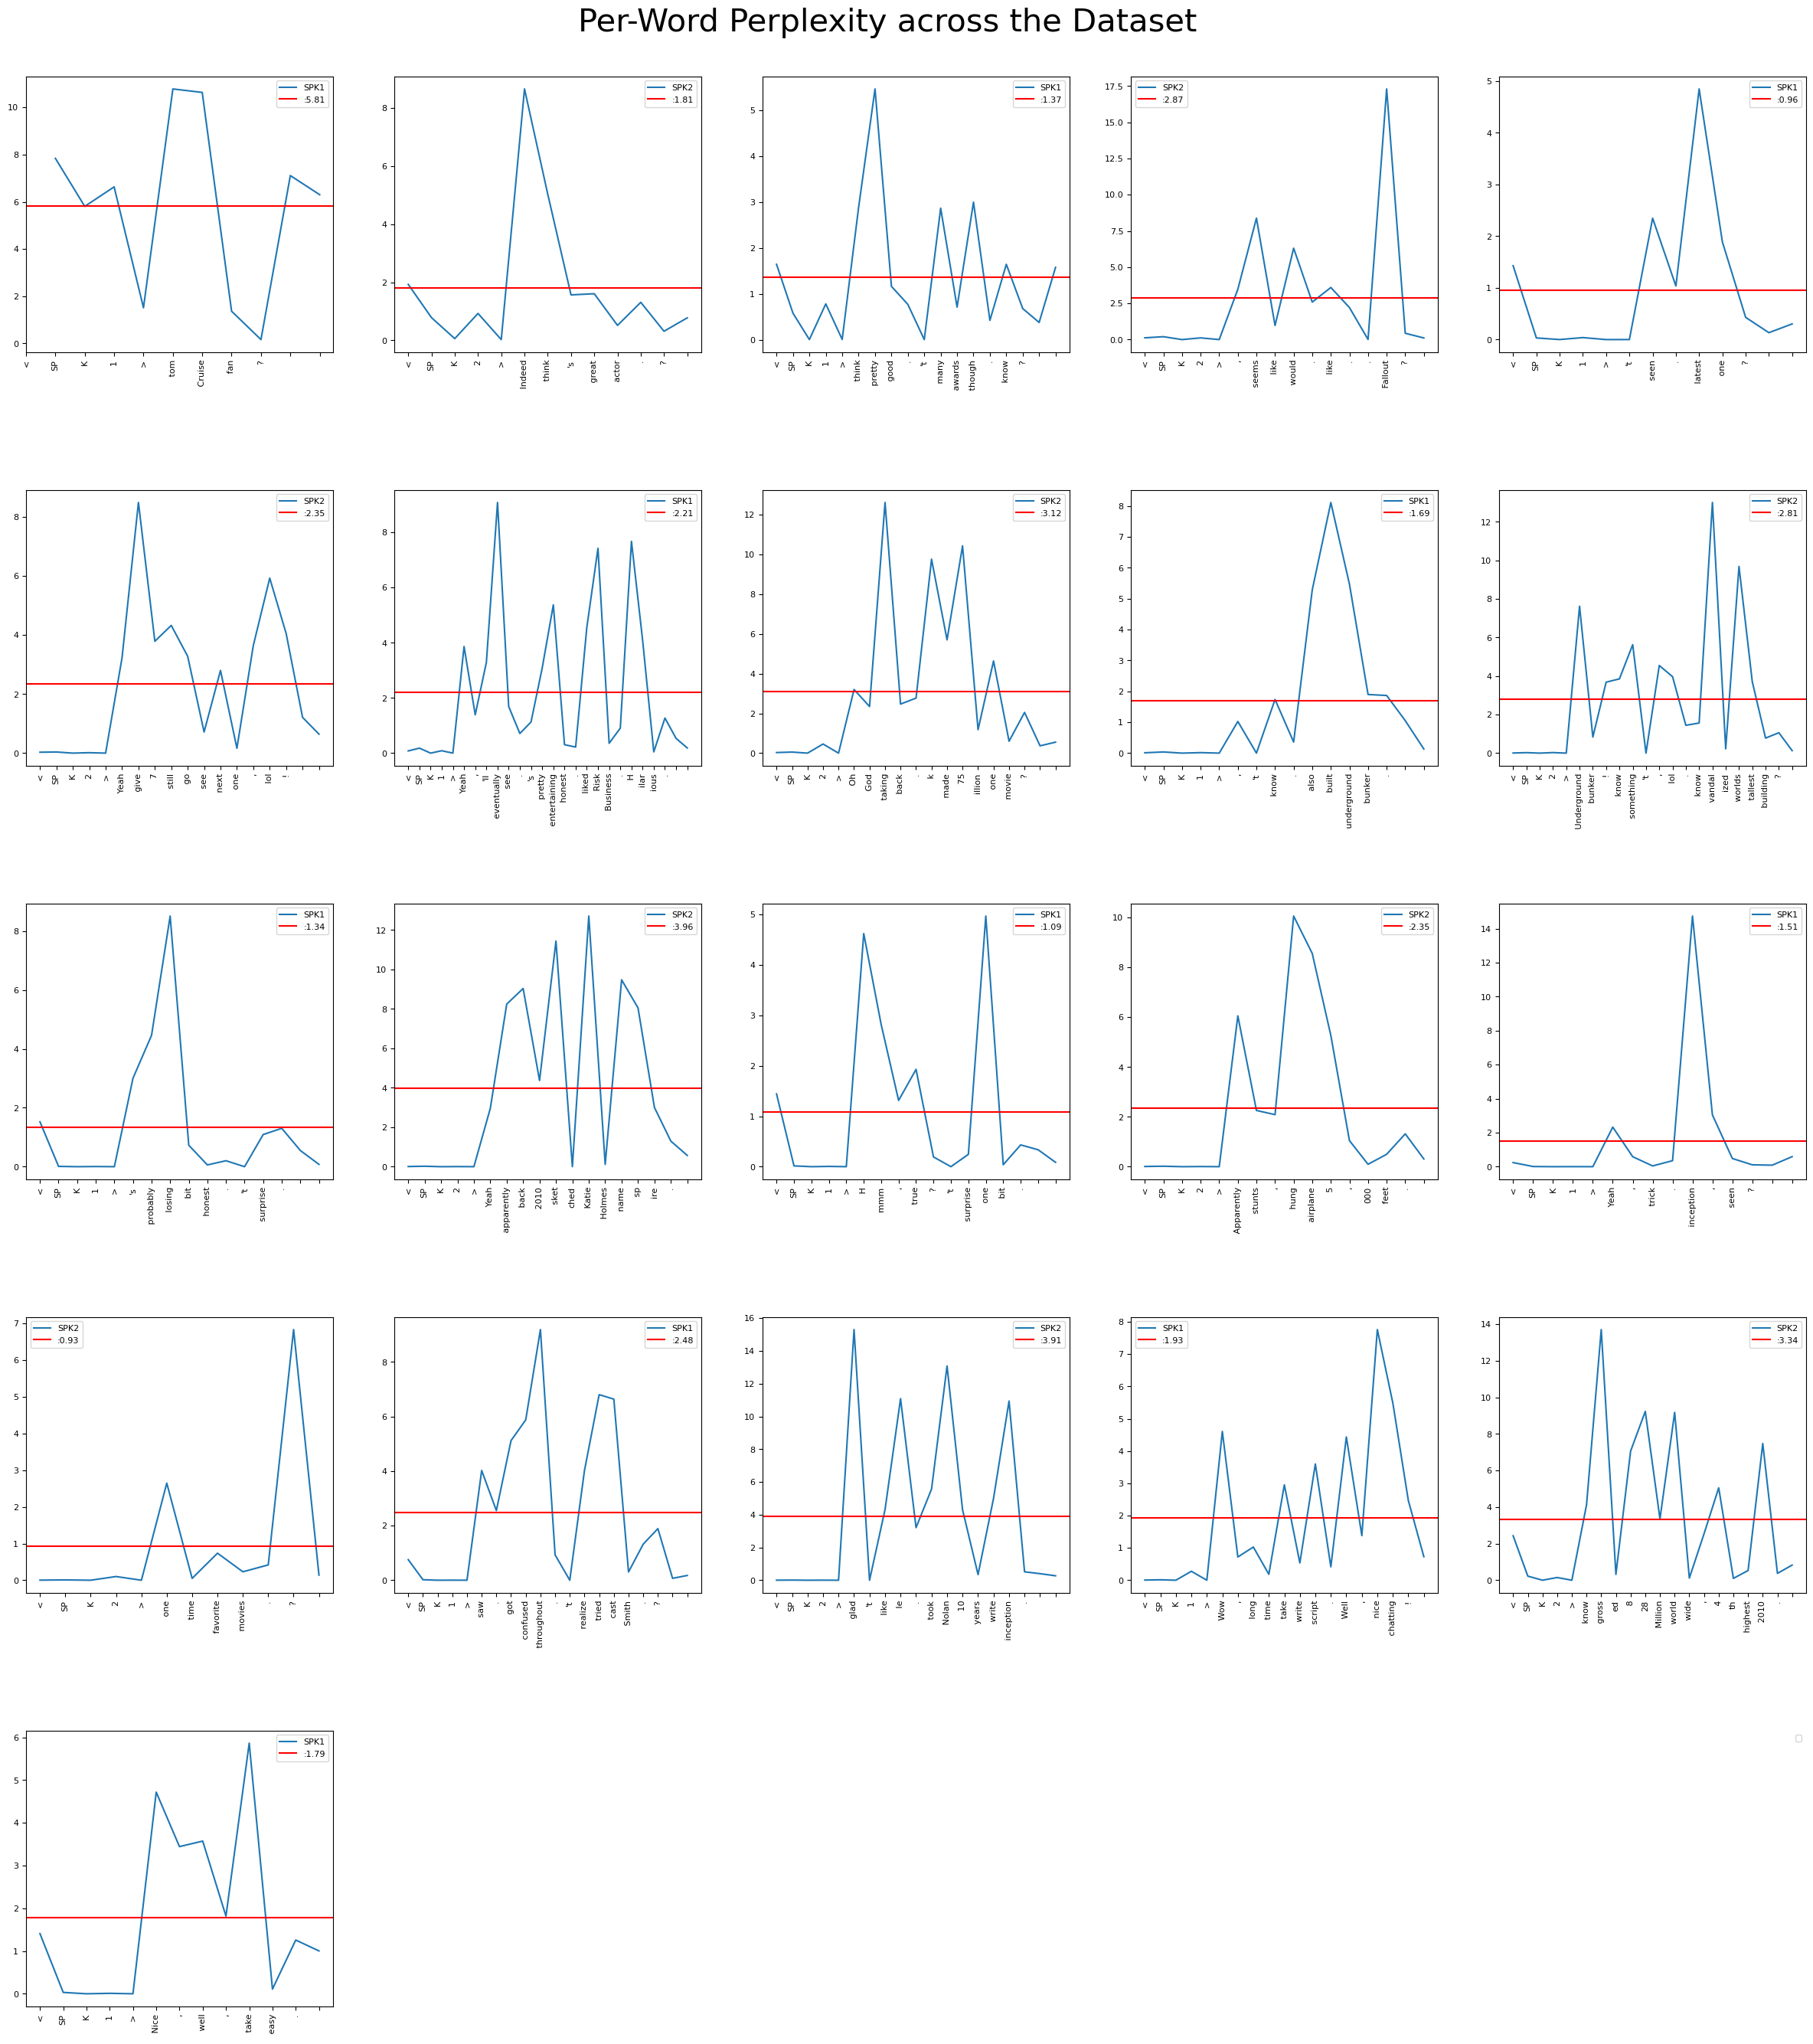

KeyError: 't_bdcd2eb9-5b08-4d28-b4d0-c31ae6457b29'

In [52]:
import re
for content, name in zip(topical_df["file_content"], topical_df["file_name"]):
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=False).input_ids.size(1)
    encodings = tokenizer([" ".join(content)], return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    dialog_filtered_tokens, info = perplexity_to_info_filtering_out_common_words(content, tokens, perplexity_scores[name],[None for _ in range(len(content))])
    perpl = []
    for el in info:
        perpl += list(el['perpl'])
    assert len(torch.cat(dialog_filtered_tokens)) == len(perpl)
    compute_graph_perplexity(dialog_filtered_tokens,perpl,pattern=pattern) 

In [9]:
dominance = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    dominance[name] = {}
    pattern = r'\[(SPK\d|MOD)\]'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\[', r'\n[', content).split("\n")[1:]
    assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores[name])
    compute_graph_perplexity(tokens,perplexity_scores[name],pattern=pattern) 

Token indices sequence length is longer than the specified maximum sequence length for this model (4955 > 1024). Running this sequence through the model will result in indexing errors

KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2c36eddab0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f2c36edd900> (for post_execute):



KeyboardInterrupt



In [10]:
dominance = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    try:
        print(name)
        dominance[name] = {}
        pattern = r'\[(SPK\d|MOD)\]'
        matches = re.findall(pattern, "".join(content))
        
        content = re.sub(r'\[', r'\n[', content).split("\n")[1:]
        assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
        result = compute_per_user_mean_perplexity_filtering_out_common_words(content,tokens,perplexity_scores[name])
        for patt in result.keys():
            if patt in np.unique(matches):
                print(f"{patt}: {np.mean(result[patt])}")
                dominance[name][patt] = np.mean(result[patt])
    except Exception as e:
        print(e)
        print(f"Excepting {name}")

S02
MOD: 2.1938900100806857
SPK1: 1.6394011346808488
SPK2: 1.4728067813563621
S03
MOD: 2.394424020800933
SPK1: 1.4517668422103673
SPK2: 1.5930861385346007
S04
MOD: 1.9284077747460755
SPK1: 1.6077657068538656
SPK2: 1.4172009455253238
S05
MOD: 2.001798955990742
SPK2: 1.4729624790092644
SPK1: 1.3260693397876266
S07
MOD: 2.1658465496090824
SPK2: 1.3592995958884635
SPK1: 1.4547867116606445
S08
MOD: 2.2395059001568667
SPK2: 1.2653238759449745
SPK1: 1.4210770453775905
S09
MOD: 2.0158995164389224
SPK2: 1.3207024582942863
SPK1: 1.6132635357789242
S10
MOD: 1.907408206488408
SPK1: 1.4986804475707642
SPK2: 1.8302830746988694
S11
SPK1: 1.5108813312758111
MOD: 1.9967422905812602
SPK2: 1.5129223941325989
S13
SPK1: 1.3535668673546202
MOD: 2.0075872263821255
SPK2: 1.4431142900549958
S14
MOD: 1.834212410589492
SPK2: 1.5145347572678012
SPK1: 1.4524953884033818
S17
MOD: 1.8903095772185705
SPK1: 1.339124236161597
SPK2: 1.214432827554456
S18
MOD: 2.138144665867579
SPK1: 1.4153878656685208
SPK2: 1.6579438204

In [ ]:
dominance = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    try:
        print(name)
        dominance[name] = {}
        pattern = r'\[(SPK\d|MOD)\]'
        matches = re.findall(pattern, "".join(content))
        
        content = re.sub(r'\[', r'\n[', content).split("\n")[1:]
        assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
        result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores[name])
        for patt in result.keys():
            if patt in np.unique(matches):
                print(f"{patt}: {np.mean(result[patt])}")
                dominance[name][patt] = np.mean(result[patt])
    except Exception as e:
        print(e)
        print(f"Excepting {name}")

S02


In [50]:
import pickle
file_path = "/u/sebono/conversational_dominance/data/processed/mean_perplexity_per-user_multisimo.pikle"
with open(file_path, 'rb') as file:
    dominance = pickle.load(file)

In [126]:
df_ppxl = pd.DataFrame(dominance).T
df_ppxl.index.name = "file_name"
final_results_ppxl_multisimo = pd.merge(multisimo_df,df_ppxl, on="file_name")

In [131]:
final_results_ppxl_multisimo

file_name  speaker_1_1  speaker_1_2  speaker_1_3  speaker_1_4  speaker_1_5  \
0        S02          3.0          2.0          2.0          2.0          1.0   
1        S03          2.0          2.0          2.0          2.0          2.0   
2        S04          2.0          1.0          2.0          4.0          1.0   
3        S05          4.0          4.0          4.0          4.0          3.0   
4        S07          4.0          2.0          3.0          4.0          4.0   
5        S08          4.0          2.0          3.0          2.0          1.0   
6        S09          4.0          3.0          3.0          5.0          3.0   
7        S10          3.0          2.0          3.0          4.0          2.0   
8        S11          5.0          2.0          3.0          3.0          5.0   
9        S13          3.0          1.0          2.0          4.0          2.0   
10       S14          4.0          3.0          3.0          4.0          3.0   
11       S17          5.0          2.0          3.0          3.0          2.0   
12       S18          5.0          3.0          3.0          3.0          3.0   
13       S19          4.0          3.0          3.0          2.0          2.0   
14       S20          5.0          4.0          4.0          5.0          3.0   
15       S21          3.0          3.0          2.0          3.0          1.0   
16       S22          4.0          2.0          3.0          5.0          3.0   
17       S23          4.0          4.0          3.0          5.0          2.0   

    speaker_2_1  speaker_2_2  speaker_2_3  speaker_2_4  speaker_2_5  \
0           4.0          3.0          3.0          4.0          3.0   
1           4.0          3.0          3.0          5.0          2.0   
2           1.0          1.0          1.0          4.0          1.0   
3           3.0          2.0          3.0          1.0          1.0   
4           4.0          2.0          3.0          5.0          3.0   
5           3.0          3.0          3.0          3.0          2.0   
6           4.0          3.0          3.0          5.0          3.0   
7           3.0          2.0          2.0          4.0          2.0   
8           2.0          1.0          2.0          1.0          1.0   
9           2.0          1.0          2.0          1.0          1.0   
10          3.0          4.0          4.0          4.0          3.0   
11          3.0          2.0          3.0          3.0          1.0   
12          2.0          1.0          2.0          1.0          1.0   
13          5.0          4.0          4.0          3.0          3.0   
14          5.0          4.0          4.0          4.0          3.0   
15          4.0          4.0          3.0          4.0          2.0   
16          4.0          3.0          4.0          4.0          3.0   
17          4.0          3.0          3.0          4.0          3.0   

    speaker_1_dom_score  speaker_2_dom_score  \
0                   2.0                  3.4   
1                   2.0                  3.4   
2                   2.0                  1.6   
3                   3.8                  2.0   
4                   3.4                  3.4   
5                   2.4                  2.8   
6                   3.6                  3.6   
7                   2.8                  2.6   
8                   3.6                  1.4   
9                   2.4                  1.4   
10                  3.4                  3.6   
11                  3.0                  2.4   
12                  3.4                  1.4   
13                  2.8                  3.8   
14                  4.2                  4.0   
15                  2.4                  3.4   
16                  3.4                  3.6   
17                  3.6                  3.4   

                                         file_content speaker_1 speaker_2  \
0   [MOD]: Ok so thanks for coming today. we're go...      P006      P007   
1    [MOD] Ok hello we are going to play a qui

In [132]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [133]:
def correlation(df_final):
        corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
        fig_corr.show()
        fig_p.show()
        fig_r2.show()
        return corr, fig_corr, p, fig_p, fig_r2

In [134]:
results = pd.DataFrame({"one":final_results_ppxl_multisimo["speaker_1_dom_score"]>final_results_ppxl_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_multisimo["SPK1"]>final_results_ppxl_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

0.3888888888888889

In [135]:
final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score","SPK1","SPK2"]]

speaker_1_dom_score  speaker_2_dom_score      SPK1      SPK2
0                   2.0                  3.4  1.639401  1.472807
1                   2.0                  3.4  1.451767  1.593086
2                   2.0                  1.6  1.607766  1.417201
3                   3.8                  2.0  1.326069  1.472962
4                   3.4                  3.4  1.454787  1.359300
5                   2.4                  2.8  1.421077  1.265324
6                   3.6                  3.6  1.613264  1.320702
7                   2.8                  2.6  1.498680  1.830283
8                   3.6                  1.4  1.510881  1.512922
9                   2.4                  1.4  1.353567  1.443114
10                  3.4                  3.6  1.452495  1.514535
11                  3.0                  2.4  1.339124  1.214433
12                  3.4                  1.4  1.415388  1.657944
13                  2.8                  3.8  1.375989  1.516017
14                  4.2                  4.0  1.634085  1.214660
15                  2.4                  3.4  1.756079  1.506281
16                  3.4                  3.6       NaN       NaN
17                  3.6                  3.4  1.296187  1.321923

In [136]:
y_s = final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score"]]
X = final_results_ppxl_multisimo[["SPK1","SPK2"]]
col_1 = list(X.keys())
col_2 = list(y_s.keys())
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score","SPK1","SPK2"]])

In [ ]:
dialog_filtered_tokens, info = perplexity_to_info_filtering_out_common_words(d,ppl_d,answers)
perpl = []
answers = []
for el in info:
    answers.append(el['label'])
    perpl += list(el['perpl'])
compute_graph_perplexity(dialog_filtered_tokens,perpl,answers=answers)

In [ ]:
###TO BE FIXED: there are some spaces that mess up the tokenization and detokenization

for el, dataset in zip(info, multisimo_df['file_content']):
    print(f"plotting {el}")
    dataset = re.sub(r'\[', r'\n[', content).split("\n")[1:]
    perplexity = []
    for sentence in info[el]:
        perplexity += list(sentence["perpl"]) 
    compute_graph_perplexity(dataset,perplexity)

In [ ]:
for i, (info_u, dataset) in enumerate(zip(info.keys(), considered_datasets_filtered)):
    for u, d in zip(info[info_u][1:], dataset.split("\n")[1:]):
        """filtering out assertive sentences like "'[Teacher]: "Very good. Continue."',
             '[Teacher]: "Please, go ahead."',
             '[Teacher]: "That\'s correct."',
             '[Teacher]: "Very good. Continue."',"""
        per_label_ppl[u['label']] += list(u['perpl'])
        per_label_dataset[u['label']].append(d)

### Tobedone when we have labels for MULTISIMO

In [ ]:
considered_datasets =multisimo_df["file_content"]

per_label_dataset={"Information seeking":[], "Information giving":[],"same":[]}
per_label_ppl={"Information seeking":[], "Information giving":[],"same":[]}

for dataset in considered_datasets:
    dataset = dataset.split("\n")
    labels = ["same" for _ in range(len(dataset))]
    encodings = tokenizer(dataset, return_tensors="pt")
    tokens_ids_per_sentence = np.cumsum([tokenizer(p, return_tensors="pt").input_ids.size(1) for p in dialog])
    prev_idx_pp = 0
    for idx, (d, l) in enumerate(zip(dataset,labels)):
        idx_pp = tokens_ids_per_sentence[idx]
        offset_ppl = len(tokenizer(d, return_tensors="pt"))
        per_label_dataset[l].append(d)
        per_label_ppl[l] += perplexity_scores[idx][prev_idx_pp:idx_pp]
        prev_idx_pp=idx_pp

### Teacher Dominated

In [92]:
import pandas as pd
file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral.csv"
datasets = pd.read_csv(file_path).reset_index()

In [39]:
ppl = {}
for index, dataset in zip(datasets["index"],datasets["transcript"]):
    dataset = dataset.split("\n")
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, "".join(dataset))    
    perpl = perplexity_of_fixedlength_models(dataset)
    ppl[index] = perpl

 11%|█████████████▍                                                                                                                 | 121/1145 [00:04<00:40, 25.18it/s]


In [40]:
#import pickle
#file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral_perplexity_scores.pikle"
#with open(file_path, 'wb') as file:
#    pickle.dump(ppl, file)

In [105]:
import pickle
file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral_perplexity_scores.pikle"
with open(file_path, 'rb') as file:
    perplexity_scores = pickle.load(file)

In [94]:
considered_indices = datasets[datasets["n_responses_match"] == True]["index"]
considered_datasets =  datasets[datasets["n_responses_match"] == True]

considered_datasets["transcript"].iloc[-1]

'[Student]: "Miss, I\'m feeling stressed about the upcoming exams. I\'m not sure how to manage it."\n[Teacher]: "It\'s normal to feel stressed before exams. But there are ways to manage it. Firstly, create a study schedule. This will help you stay organized and reduce anxiety."\n[Student]: "I have a schedule but I still feel overwhelmed."\n[Teacher]: "In that case, try some relaxation techniques like deep breathing or meditation. Also, make sure to take breaks and get enough sleep."\n[Student]: "I\'ll try that. Thank you, Miss."'

In [96]:
import re

considered_indices = datasets[datasets["n_responses_match"] == True]["index"]
considered_datasets =  datasets[datasets["n_responses_match"] == True]

per_label_dataset={"Information seeking":[],"Neutral": [],  "Information giving":[]}
per_label_ppl={"Information seeking":[], "Neutral": [], "Information giving":[]}

info = {}
considered_datasets_filtered = []
for dataset, response, ppl_idx in zip(considered_datasets["transcript"],considered_datasets["response"], considered_indices):
    #encodings = [tokenizer(d, return_tensors="pt").input_ids[0] for d in dataset.split("\n")]
    dataset = dataset.split("\n")
    encodings = tokenizer(" ".join(dataset), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    dataset_filtered, info[ppl_idx] = perplexity_to_info_filtering_out_common_words(dataset,encodings,perplexity_scores[ppl_idx],response.split("\n"))
    considered_datasets_filtered.append(dataset_filtered)

In [44]:
per_label_ppl

{'Information seeking': [], 'Neutral': [], 'Information giving': []}

In [45]:
per_label_dataset={"Information seeking":[],"Neutral": [],  "Information giving":[]}
per_label_ppl={"Information seeking":[], "Neutral": [], "Information giving":[]}
for i, (info_u, dataset) in enumerate(zip(info.keys(), considered_datasets_filtered)):
    for u, d in zip(info[info_u], dataset):
        """filtering out assertive sentences like "'[Teacher]: "Very good. Continue."',
             '[Teacher]: "Please, go ahead."',
             '[Teacher]: "That\'s correct."',
             '[Teacher]: "Very good. Continue."',"""
        assert len(u['perpl']) == len(d)
        per_label_ppl[u['label']] += list(u['perpl'])
        per_label_dataset[u['label']].append(d)

56 56


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


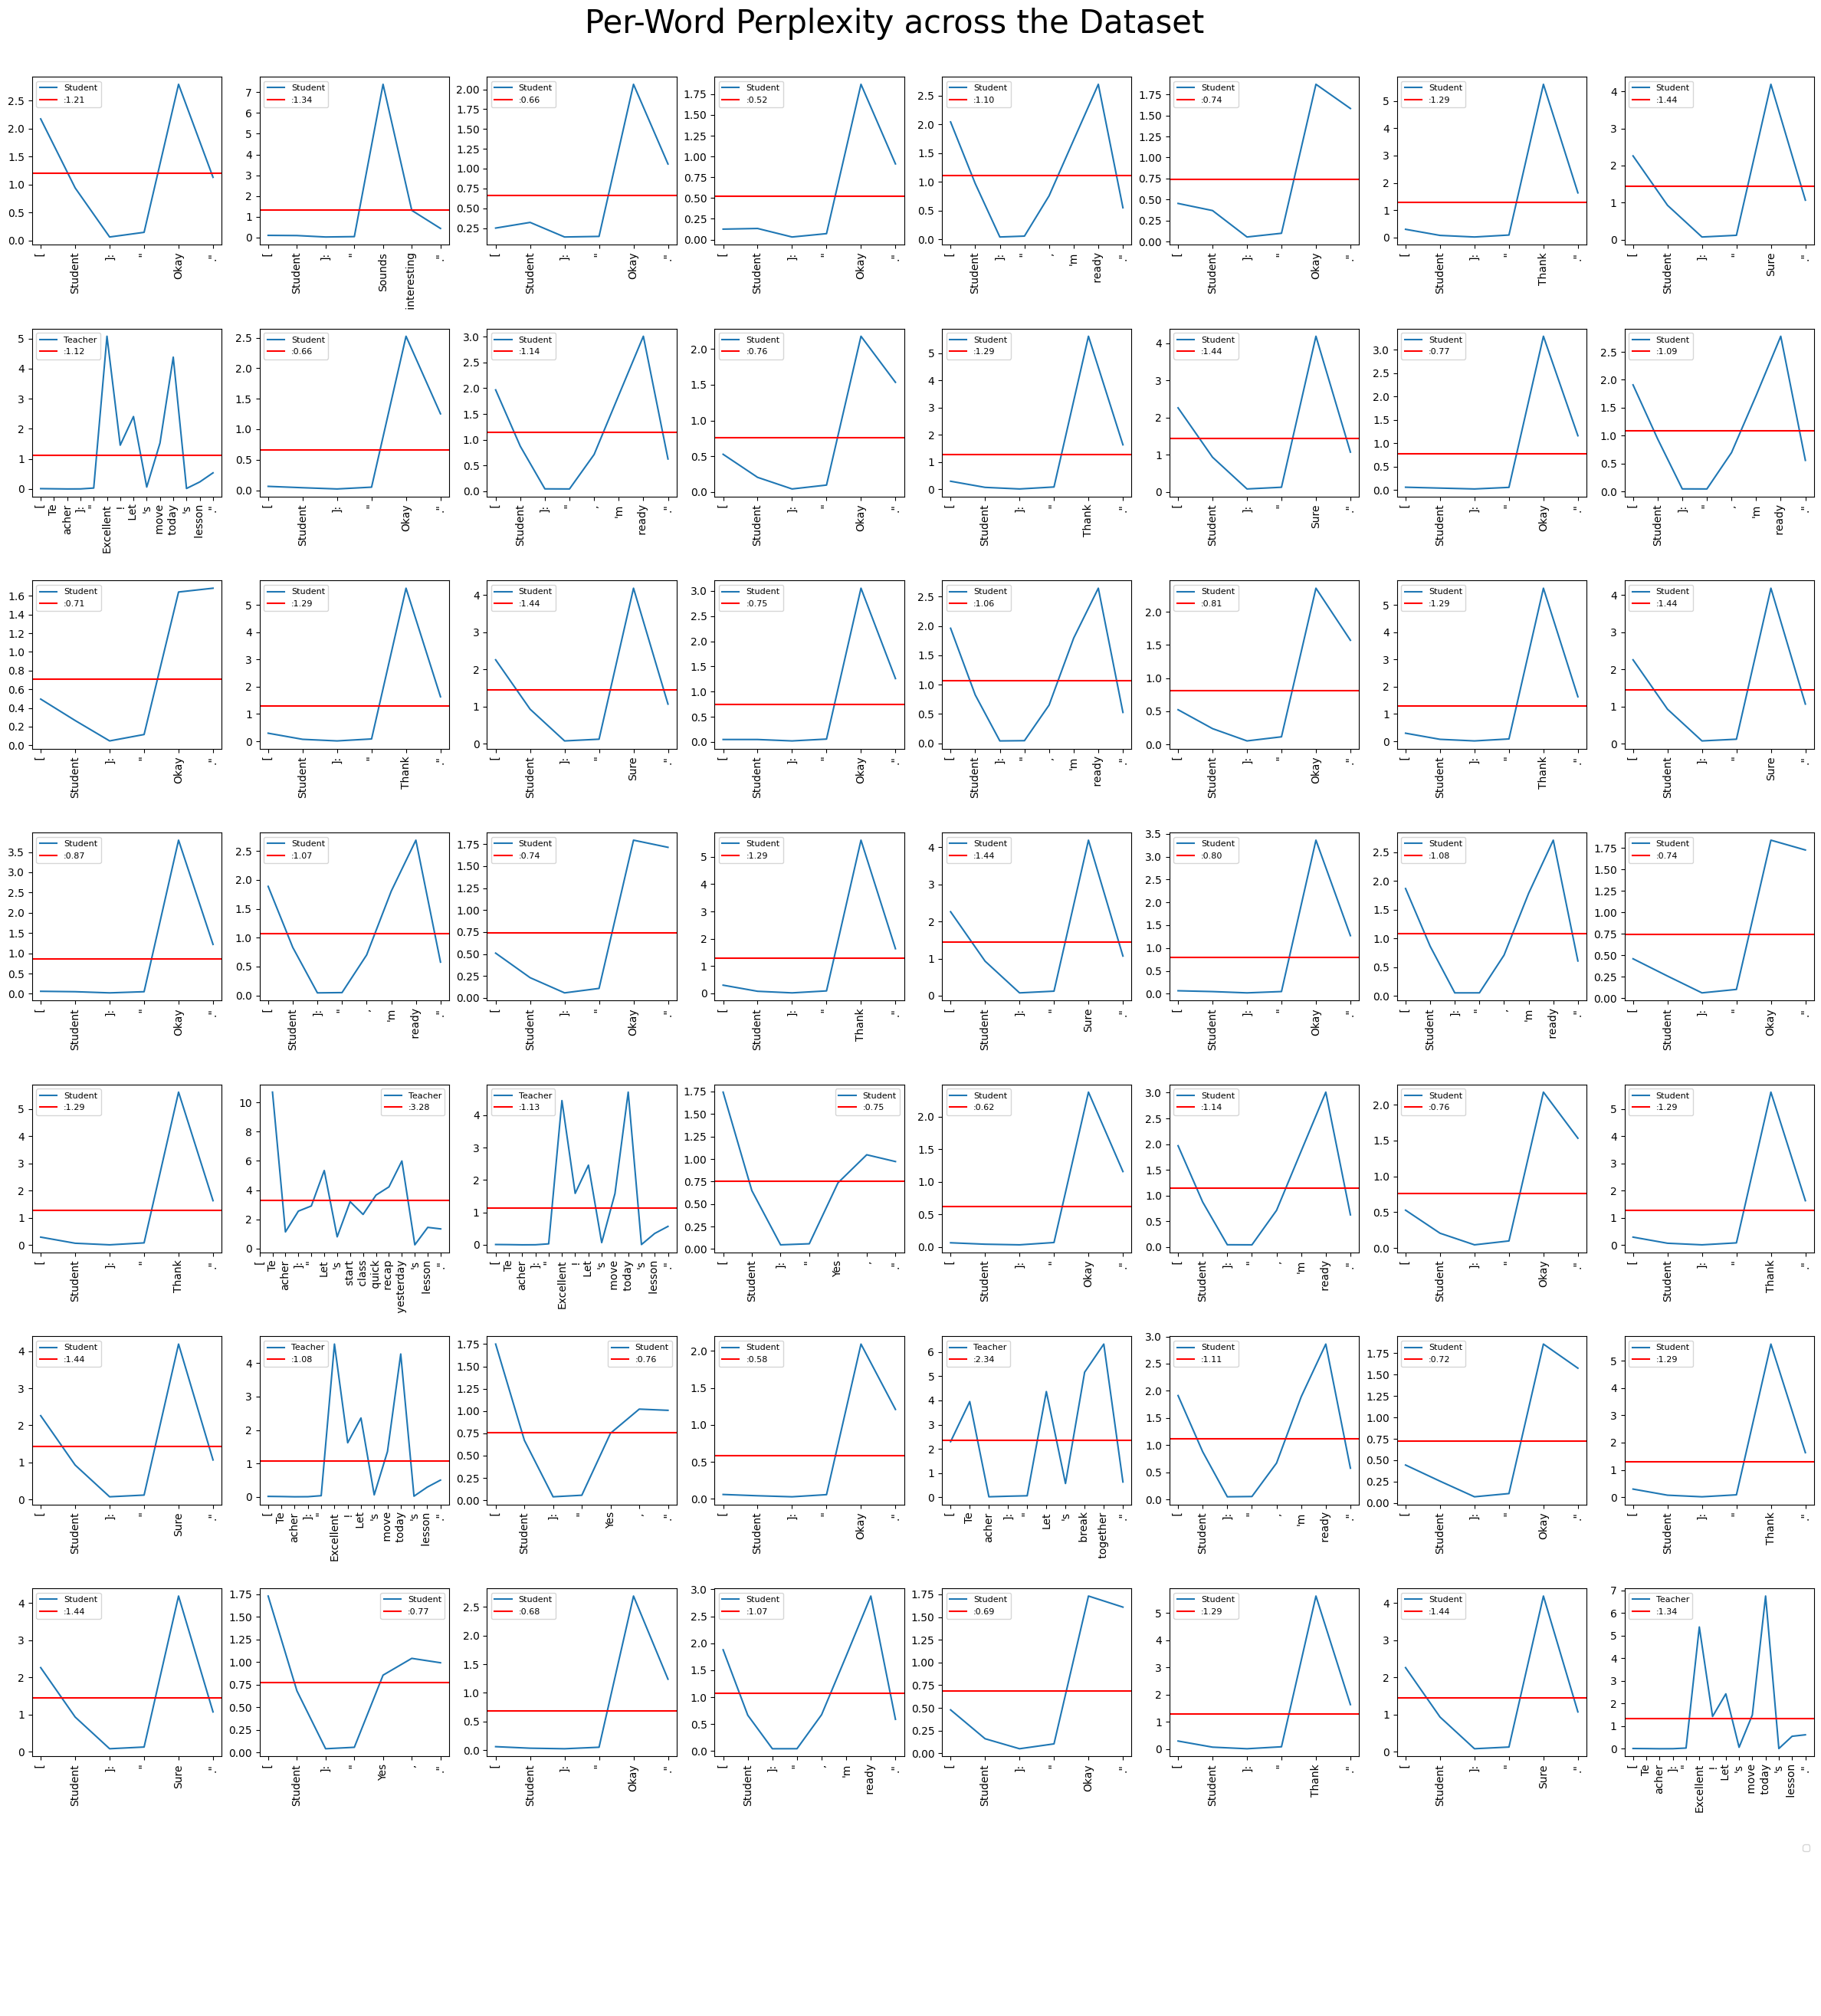

In [13]:
#information giving
pattern = r'\[([^\]]+)\]'
tokens = per_label_dataset["Neutral"]
perplexity = per_label_ppl["Neutral"]
compute_graph_perplexity(tokens, perplexity,pattern=pattern)

228 228


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


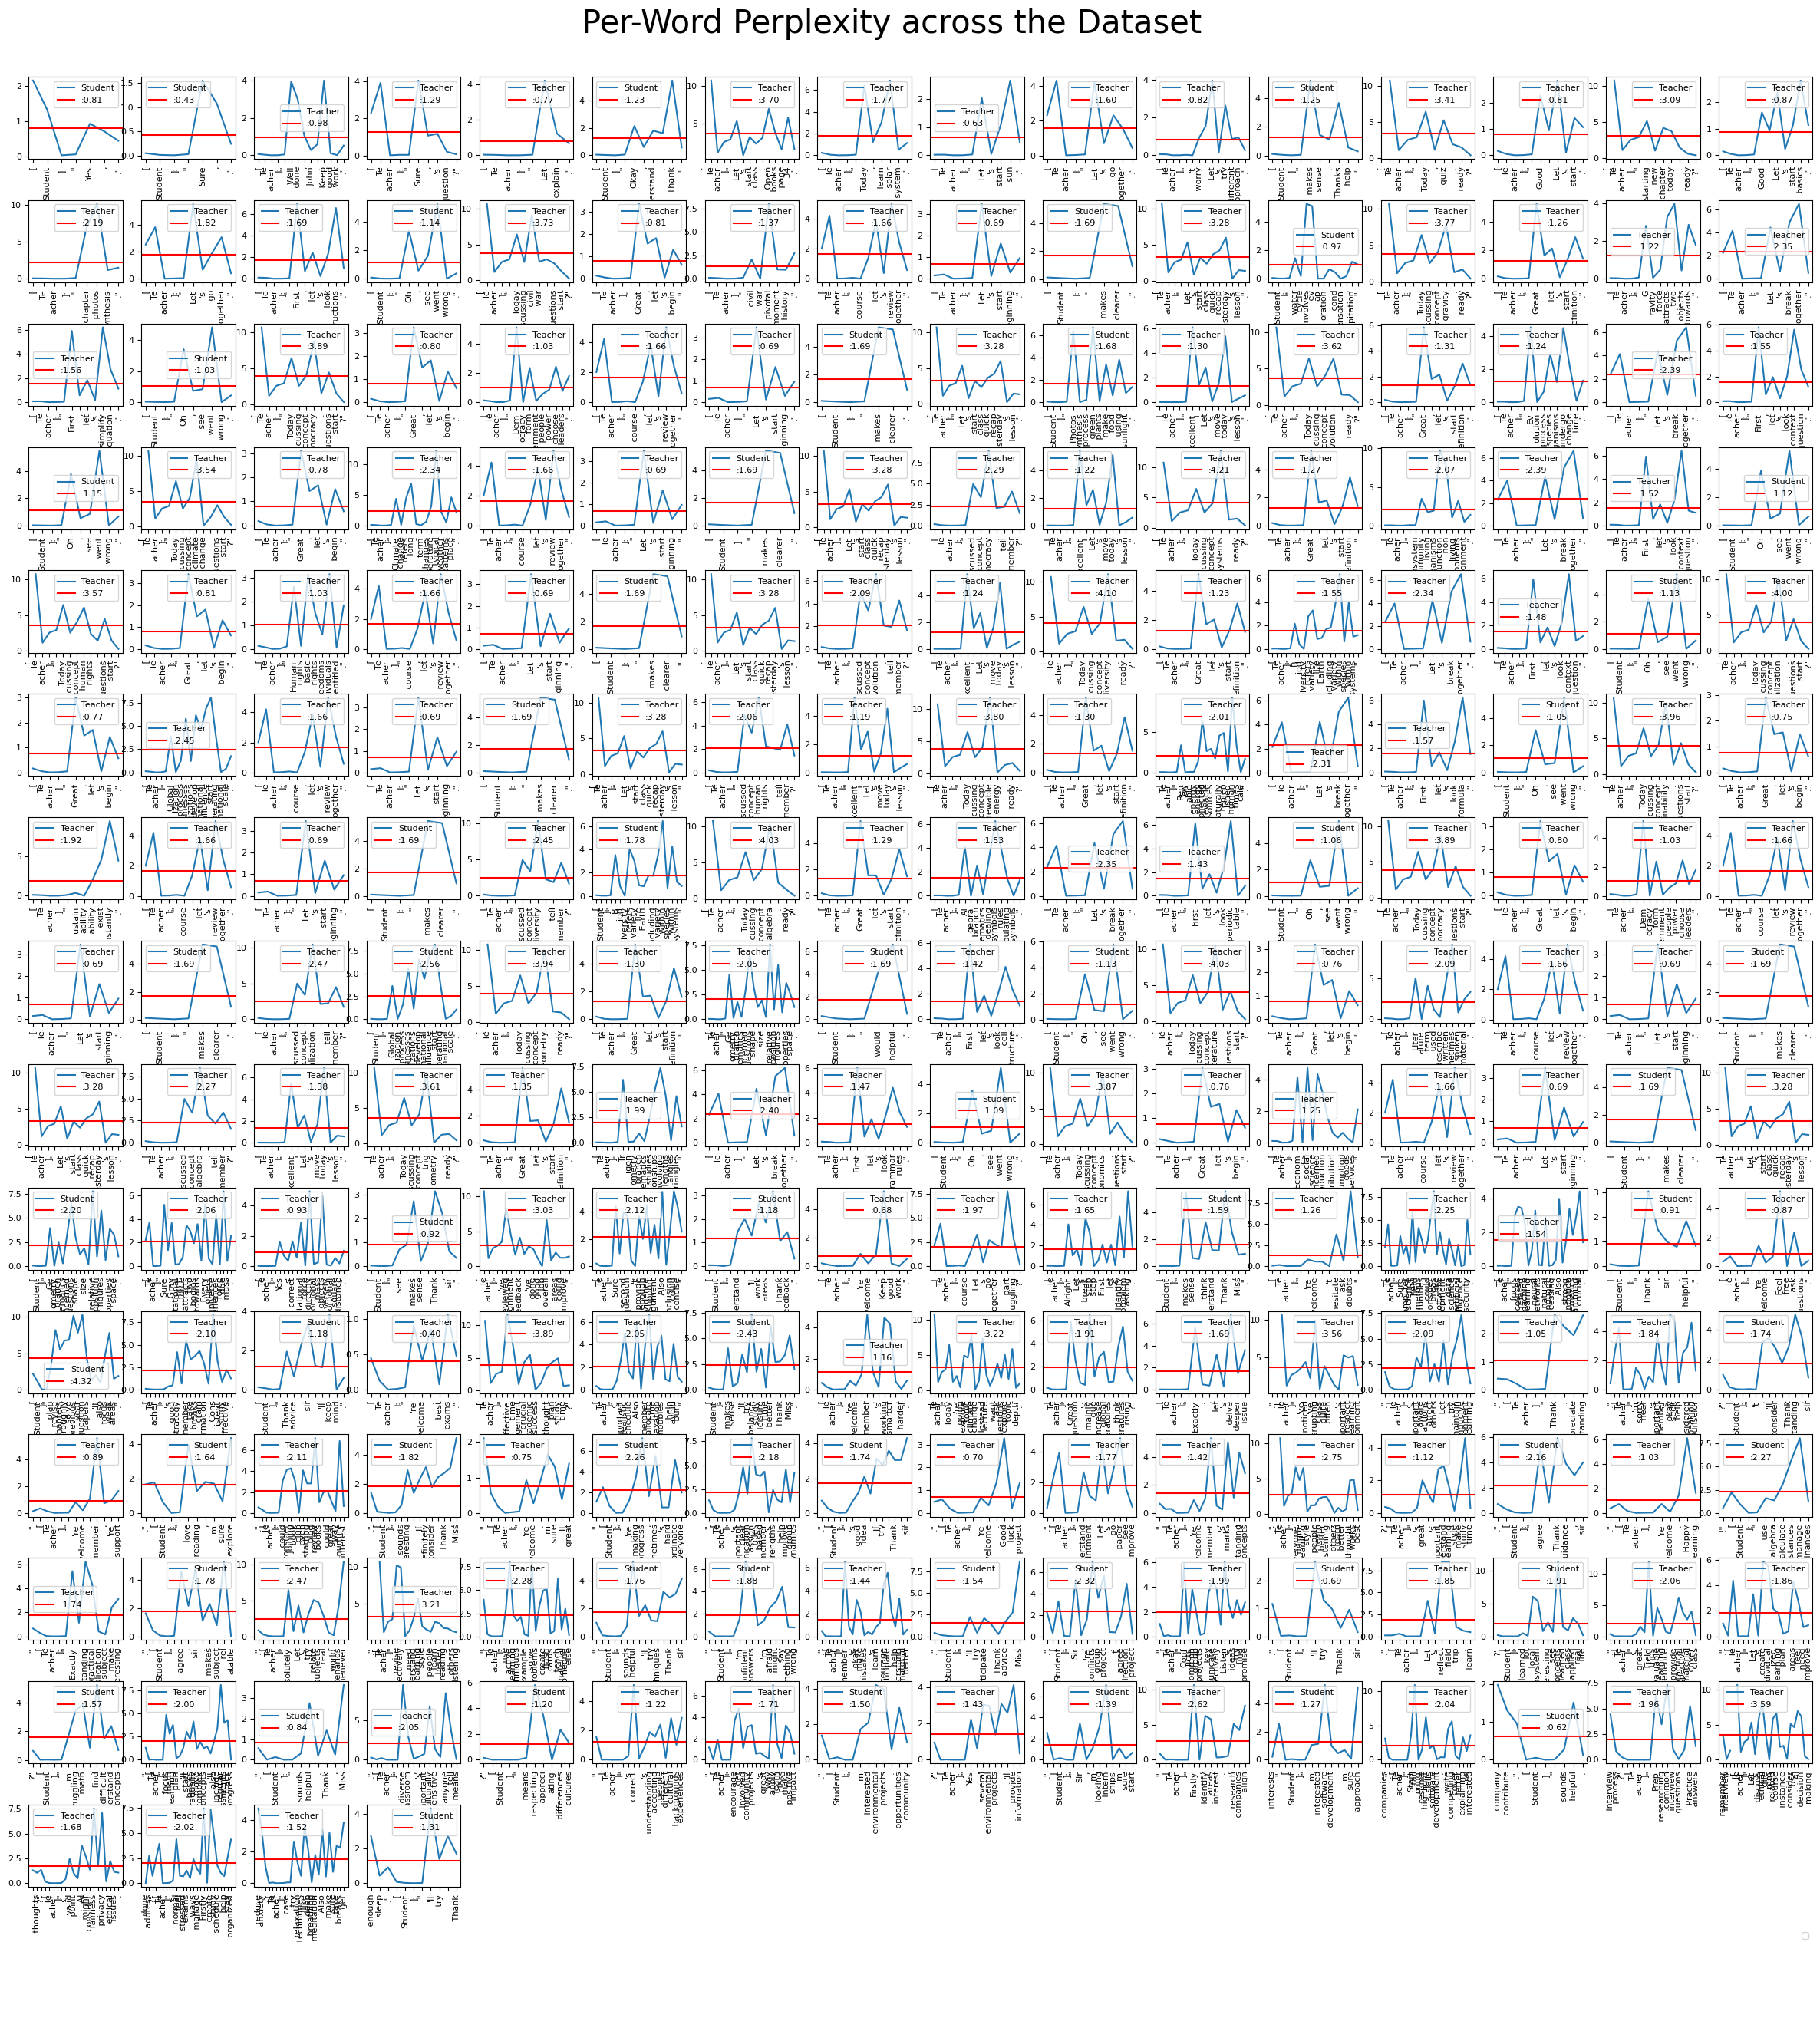

In [92]:
#information giving
tokens = per_label_dataset["Information giving"]
perplexity = per_label_ppl["Information giving"]
compute_graph_perplexity(tokens, perplexity)

In [47]:
len(per_label_ppl["Information giving"]), len(per_label_dataset["Information giving"])

(3160, 228)

In [48]:
perplexity = per_label_ppl["Neutral"]
np.nanmean(perplexity), np.nanstd(perplexity)

(1.1604389851036556, 1.5398975316169117)

In [49]:
perplexity = per_label_ppl["Information giving"]
np.nanmean(perplexity), np.nanstd(perplexity)

(1.8934864565744087, 2.3271623602469513)

In [50]:
perplexity = per_label_ppl["Information seeking"]
np.nanmean(perplexity), np.nanstd(perplexity)

(2.4934355537602264, 2.7126114845916796)

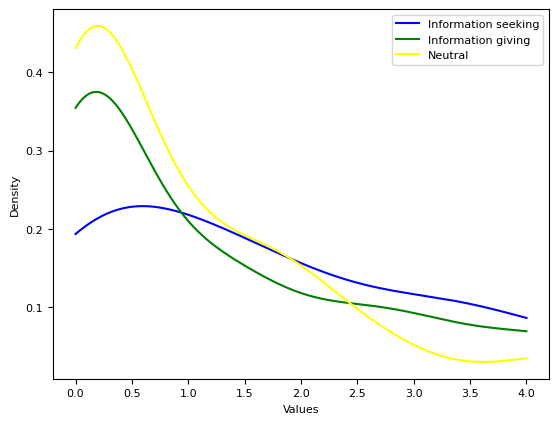

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming per_label_ppl is a dictionary containing data for "Information seeking" and "Information giving"

# Create a figure and axis
fig, ax = plt.subplots()

# Plot KDE using seaborn
sns.kdeplot(per_label_ppl["Information seeking"], color='blue', label='Information seeking', ax=ax, cut=0, clip=(0, 4))
sns.kdeplot(per_label_ppl["Information giving"], color='green', label='Information giving', ax=ax, cut=0, clip=(0, 4))
sns.kdeplot(per_label_ppl["Neutral"], color='yellow', label='Neutral', ax=ax, cut=0, clip=(0, 4))

# Adding labels and legend
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.legend()

# Display the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming per_label_ppl is a dictionary containing data for "Information seeking" and "Information giving"

# Create a figure and axis
fig, ax = plt.subplots()

# Plot histograms using seaborn with density=True
sns.histplot(per_label_ppl["Information seeking"], kde=True, color='blue', label='Information seeking', ax=ax, stat='density')
sns.histplot(per_label_ppl["Information giving"], kde=True, color='green', label='Information giving', ax=ax, stat='density')
sns.histplot(per_label_ppl["Neutral"], kde=True, color='yellow', label='Neutral', ax=ax, stat='density')

# Adding labels and legend
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.legend()

# Display the plot
plt.show()


In [ ]:
#lower perplexity
dataset = per_label_dataset["Information seeking"]
perplexity = per_label_ppl["Information seeking"]
pattern = r'\[([^\]]+)\]'
compute_graph_perplexity(dataset,perplexity)